Import Libraries and GPU Setup

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
import time
from datetime import datetime
import matplotlib.pyplot as plt
import random

warnings.filterwarnings('ignore')

# ==============================================================================
# GPU SETUP AND CONFIGURATION
# ==============================================================================

def setup_gpu():
    """Check and setup GPU if available"""
    print("GPU Setup Check:")
    print("=" * 30)
    
    cuda_available = torch.cuda.is_available()
    print(f"CUDA Available: {cuda_available}")
    
    if cuda_available:
        gpu_count = torch.cuda.device_count()
        print(f"Number of GPUs: {gpu_count}")
        
        for i in range(gpu_count):
            gpu_name = torch.cuda.get_device_name(i)
            gpu_memory = torch.cuda.get_device_properties(i).total_memory / (1024**3)
            print(f"GPU {i}: {gpu_name} ({gpu_memory:.1f} GB)")
        
        if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
            torch.cuda.set_per_process_memory_fraction(0.8)
            print("Set GPU memory fraction to 80%")
        
        return torch.device('cuda')
    else:        
        return torch.device('cpu')

# Set device
device = setup_gpu()
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
print(f"Using device: {device}")
print()


GPU Setup Check:
CUDA Available: False
PyTorch version: 2.5.1+cu121
Using device: cpu



#### Dataset Exploration and Structure Analysis

In [4]:
def explore_dataset(data_dir):
    """Explore the BRISC dataset structure"""
    print("📊 Dataset Structure Analysis:")
    print("=" * 40)
    
    # Check classification data
    class_dir = os.path.join(data_dir, 'classification_task')
    
    if os.path.exists(class_dir):
        
        for split in ['train', 'test']:
            split_dir = os.path.join(class_dir, split)
            
            if os.path.exists(split_dir):
                print(f"\n🧠 {split.capitalize()} Classification Data:")
                classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
                
                for class_name in classes:
                    class_path = os.path.join(split_dir, class_name)
                    
                    if os.path.exists(class_path):
                        count = len([f for f in os.listdir(class_path) 
                                     
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                        print(f"   {class_name}: {count} images")
                        
    
    # Check segmentation data
    seg_dir = os.path.join(data_dir, 'segmentation_task')
    
    
    if os.path.exists(seg_dir):
        print(f"\n🎯 Segmentation Data:")
        
        for split in ['train', 'test']:
            split_dir = os.path.join(seg_dir, split)
            
            if os.path.exists(split_dir):
                images_dir = os.path.join(split_dir, 'images')
                
                masks_dir = os.path.join(split_dir, 'masks')
                if os.path.exists(images_dir):
                    
                    img_count = len([f for f in os.listdir(images_dir) 
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    
                    mask_count = len([f for f in os.listdir(masks_dir) 
                                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]) if os.path.exists(masks_dir) else 0
                    
                    print(f"   {split.capitalize()}: {img_count} images, {mask_count} masks")

# Execute dataset exploration
data_dir = 'brisc2025'
explore_dataset(data_dir)

📊 Dataset Structure Analysis:

🧠 Train Classification Data:
   glioma: 1147 images
   meningioma: 1329 images
   no_tumor: 1067 images
   pituitary: 1457 images

🧠 Test Classification Data:
   glioma: 254 images
   meningioma: 306 images
   no_tumor: 140 images
   pituitary: 300 images

🎯 Segmentation Data:
   Train: 3933 images, 3933 masks
   Test: 860 images, 860 masks


#### Custom Dataset Implementation for Brain Tumor Data

In [5]:
# ==============================================================================
# DATA LOADING AND PREPROCESSING
# ==============================================================================

class BRISCDataset(Dataset):
    
    def __init__(self, data_dir, task='segmentation', split='train', target_size=(256, 256)):
        
        self.data_dir = data_dir
        self.task = task
        self.split = split
        self.target_size = target_size
        self.samples = []
        
        # Define transforms that are applied after geometric augmentations
        self.to_tensor_transform = transforms.ToTensor()
        self.normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        if task == 'segmentation':
            self._load_segmentation_data()
        elif task == 'classification':
            self._load_classification_data()
            
        else:
            raise ValueError("Task must be 'segmentation' or 'classification'")


    def _load_segmentation_data(self):

        seg_dir = os.path.join(self.data_dir, 'segmentation_task', self.split)
        images_dir = os.path.join(seg_dir, 'images')
        masks_dir = os.path.join(seg_dir, 'masks')

        if not (os.path.exists(images_dir) and os.path.exists(masks_dir)):
            return

        image_files = sorted([f for f in os.listdir(images_dir) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])


        if self.split == 'train':
            class_splits = {
                'glioma': 1147,
                'meningioma': 1329,
                'no_tumor': 0,
                'pituitary': 1457
            }
        else:  # test
            class_splits = {
                'glioma': 254,
                'meningioma': 306,
                'no_tumor': 0,
                'pituitary': 300
            }

        # Assign labels based on sequential ranges
        idx = 0
        for class_idx, (class_name, count) in enumerate(class_splits.items()):
            for i in range(count):
                if idx >= len(image_files):
                    break
                img_file = image_files[idx]
                img_path = os.path.join(images_dir, img_file)

                # Find mask
                base_name = os.path.splitext(img_file)[0]
                possible_mask_files = [f for f in os.listdir(masks_dir) if f.startswith(base_name)]
                if not possible_mask_files:
                    idx += 1
                    continue

                mask_path = os.path.join(masks_dir, possible_mask_files[0])

                self.samples.append({
                    'image': img_path,
                    'mask': mask_path,
                    'label': class_idx
                })

                idx += 1

    
    def _load_classification_data(self):

        class_dir = os.path.join(self.data_dir, 'classification_task', self.split)
        classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
        
        for class_idx, class_name in enumerate(classes):
            
            class_path = os.path.join(class_dir, class_name)
            
            if os.path.exists(class_path):
                
                for img_file in os.listdir(class_path):
                    
                    img_path = os.path.join(class_path, img_file)
                    
                    self.samples.append({
                        'image': img_path,
                        'mask': None,
                        'label': class_idx
                    })
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Image loading
        image = Image.open(sample['image']).convert("RGB").resize(self.target_size)

        mask = None
        if self.task == 'segmentation' and sample['mask']:
            mask = Image.open(sample['mask']).convert("L").resize(self.target_size)

        # Apply same random augmentations to both image and mask
        if self.split == 'train' and self.task == 'segmentation':
            # Random Horizontal Flip
            if np.random.rand() > 0.5:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)
            
            # Random Vertical Flip
            if np.random.rand() > 0.5:
                image = transforms.functional.vflip(image)
                mask = transforms.functional.vflip(mask)

            # Random Rotation
            angle = transforms.RandomRotation.get_params([-30, 30])
            image = transforms.functional.rotate(image, angle)
            mask = transforms.functional.rotate(mask, angle)

        # Convert to tensor
        image = self.to_tensor_transform(image)

        result = {'image_path': sample['image']}

        if mask is not None:
            mask = np.array(mask)
            mask = (mask > 127).astype(np.float32)
            mask = torch.from_numpy(mask).unsqueeze(0)
            result['mask'] = mask
        
        # Apply normalization ONLY to the image
        image = self.normalize_transform(image)
        result['image'] = image

        if sample['label'] is not None:
            result['label'] = torch.tensor(sample['label'], dtype=torch.long)
        
        return result

# dataset instances
print("Creating Dataset Instances...")

seg_train = BRISCDataset(data_dir, task='segmentation', split='train')
seg_test = BRISCDataset(data_dir, task='segmentation', split='test')

class_train = BRISCDataset(data_dir, task='classification', split='train')
class_test = BRISCDataset(data_dir, task='classification', split='test')

print(f"Datasets created successfully:")
print(f"Segmentation - Train: {len(seg_train)}, Test: {len(seg_test)}")
print(f"Classification - Train: {len(class_train)}, Test: {len(class_test)}")

Creating Dataset Instances...
Datasets created successfully:
Segmentation - Train: 3933, Test: 860
Classification - Train: 5000, Test: 1000


### Sample Data Visualization - Understanding the Problem

🎨 Visualizing Classification Samples:


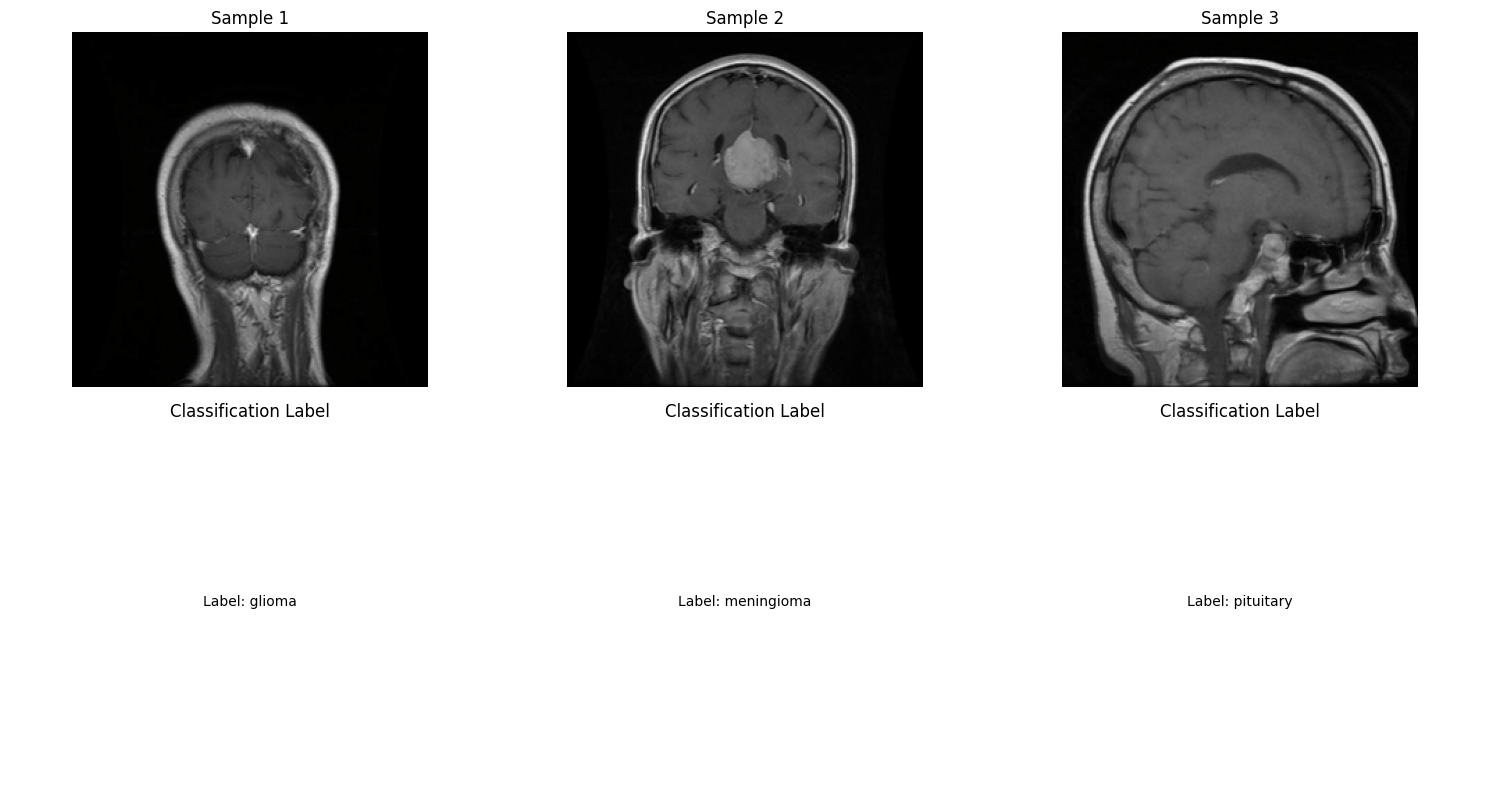


🎨 Visualizing Segmentation Samples:


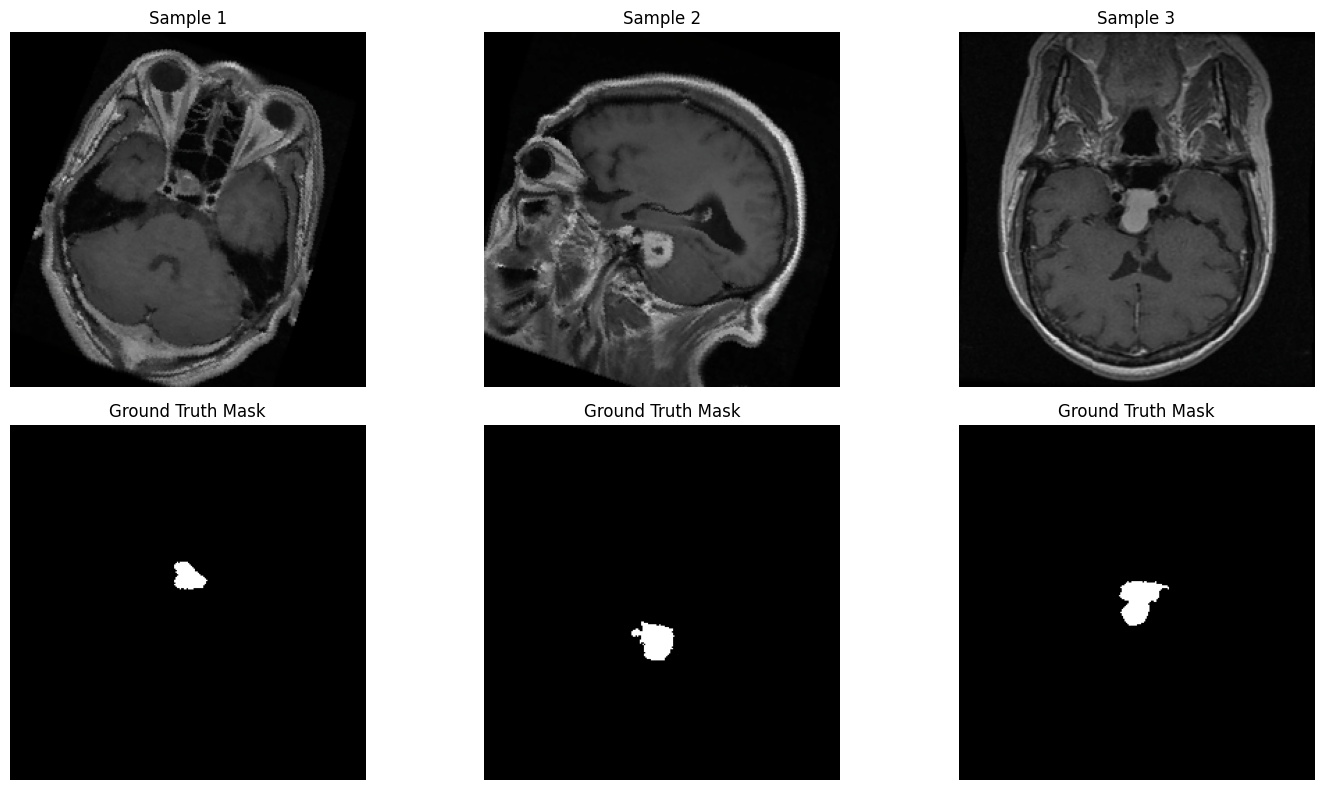

In [5]:
# Include your visualization functions
def visualize_samples(dataset, num_samples=4):

    if len(dataset) == 0:
        print("No samples to visualize")
        return
        
    num_samples = min(num_samples, len(dataset))
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    if num_samples == 1:
        axes = axes.reshape(2, 1)
    
    for i in range(num_samples):
        
        idx = random.randint(0, len(dataset) - 1)  
        sample = dataset[idx] 
        image = sample['image'].permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)
        
        axes[0, i].imshow(image)
        axes[0, i].set_title(f'Sample {i+1}')
        axes[0, i].axis('off')
        
        if 'mask' in sample and sample['mask'] is not None:
            mask = sample['mask'].squeeze().numpy()
            axes[1, i].imshow(mask, cmap='gray')
            axes[1, i].set_title('Ground Truth Mask')
            
        elif 'label' in sample and sample['label'] is not None:
            
            label = sample['label'].item()
            class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
            axes[1, i].text(0.5, 0.5, f'Label: {class_names[label]}', 
                          transform=axes[1, i].transAxes, ha='center', va='center')
            axes[1, i].set_title('Classification Label')
            
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("🎨 Visualizing Classification Samples:")
visualize_samples(class_train, num_samples=3)

print("\n🎨 Visualizing Segmentation Samples:")
visualize_samples(seg_train, num_samples=3)

# Deep Learning Model Architectures Implementation

## Weight Initialization
Proper weight initialization is crucial for training stability. We use Kaiming initialization for convolutional layers, which is optimal for ReLU activations.

In [6]:
def init_weights(m):
    
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

## Double Convolution Block

The fundamental building block of U-Net: two 3x3 convolutions, each followed by batch normalization and ReLU activation. This pattern appears throughout the network.

In [7]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

# Test the building block
test_input = torch.randn(1, 3, 64, 64)
double_conv = DoubleConv(3, 32)
output = double_conv(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 32, 64, 64])


## Standard U-Net Implementation

The classic U-Net architecture with:
- **Encoder (Downsampling):** Captures context through progressive downsampling
- **Bottleneck:** Processes the most abstract features
- **Decoder (Upsampling):** Recovers spatial resolution using skip connections
- **Skip Connections:** Preserve fine-grained details from encoder to decoder

In [8]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder (downsampling path)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # Decoder (upsampling path)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.apply(init_weights)
    
    def forward(self, x):
        skip_connections = []
        
        # Encoder forward pass
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        # Decoder forward pass
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # Upsampling
            skip_connection = skip_connections[idx//2]
            
            # Handle size mismatch
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            
            # Concatenate skip connection
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)  # Double conv
        
        return torch.sigmoid(self.final_conv(x))

# Test the U-Net
unet = UNet(in_channels=3, out_channels=1)
test_input = torch.randn(2, 3, 256, 256)
output = unet(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Parameters: {sum(p.numel() for p in unet.parameters()):,}")

Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 1, 256, 256])
Parameters: 7,765,985


## Attention Gate

Attention gates help the model focus on relevant features by learning to suppress irrelevant regions. They use gating signals from coarser scales to highlight salient features at finer scales.

In [9]:
class AttentionGate(nn.Module):

    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        # g: gating signal from coarser scale
        # x: feature map from skip connection
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi  # Element-wise multiplication

# Visualize attention mechanism
print("Attention Gate computes: attention_map = sigmoid(W_g(g) + W_x(x))")
print("Output = x * attention_map (element-wise)")

Attention Gate computes: attention_map = sigmoid(W_g(g) + W_x(x))
Output = x * attention_map (element-wise)


## Attention U-Net

Enhanced U-Net with attention gates that automatically learn to focus on target structures of varying shapes and sizes. Particularly effective for medical image segmentation where precise localization is crucial.

In [10]:
class AttentionUNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        
        super(AttentionUNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.attention_gates = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # Decoder with attention gates
        for i, feature in enumerate(reversed(features)):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            
            self.ups.append(DoubleConv(feature*2, feature))
            
            if i < len(features) - 1:
                self.attention_gates.append(
                    AttentionGate(F_g=feature, F_l=feature, F_int=feature//2)
                )
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.apply(init_weights)
    
    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for down in self.downs:
            
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        # Decoder with attention
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            # Apply attention gate
            if idx//2 < len(self.attention_gates):
                skip_connection = self.attention_gates[idx//2](x, skip_connection)
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        
        return torch.sigmoid(self.final_conv(x))
    

# Compare models
att_unet = AttentionUNet(in_channels=3, out_channels=1)
print(f"Standard U-Net parameters: {sum(p.numel() for p in unet.parameters()):,}")
print(f"Attention U-Net parameters: {sum(p.numel() for p in att_unet.parameters()):,}")

Standard U-Net parameters: 7,765,985
Attention U-Net parameters: 7,853,578


## U-Net with Classification Head

Multi-task learning approach that performs both segmentation and classification simultaneously. This can improve feature learning through shared representations and is useful when you need both pixel-level segmentation and image-level classification.

In [11]:
class UNetWithClassification(nn.Module):

    def __init__(self, in_channels=3, seg_out_channels=1, num_classes=4, features=[32, 64, 128, 256]):
        super(UNetWithClassification, self).__init__()
        self.unet = UNet(in_channels, seg_out_channels, features)
        
        # Classification head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(features[-1]*2, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        self.apply(init_weights)
    
    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for down in self.unet.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.unet.pool(x)
        
        # Bottleneck
        bottleneck_features = self.unet.bottleneck(x)
        
        # Classification branch
        class_features = self.global_pool(bottleneck_features)
        class_features = class_features.view(class_features.size(0), -1)
        classification = self.classifier(class_features)
        
        # Segmentation branch (decoder)
        x = bottleneck_features
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.unet.ups), 2):
            x = self.unet.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.unet.ups[idx+1](concat_skip)
        
        segmentation = torch.sigmoid(self.unet.final_conv(x))
        
        return segmentation, classification

# Test multi-task model
multi_unet = UNetWithClassification(in_channels=3, seg_out_channels=1, num_classes=4)
seg_output, class_output = multi_unet(test_input)
print(f"Segmentation output shape: {seg_output.shape}")
print(f"Classification output shape: {class_output.shape}")

Segmentation output shape: torch.Size([2, 1, 256, 256])
Classification output shape: torch.Size([2, 4])


In [13]:
# Quick architecture visualization
def print_model_summary(model, model_name):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{model_name}:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Model size (MB): {total_params * 4 / 1024 / 1024:.2f}")

print_model_summary(unet, "Standard U-Net")
print_model_summary(att_unet, "Attention U-Net") 
print_model_summary(multi_unet, "Multi-task U-Net")


Standard U-Net:
  Total parameters: 7,765,985
  Trainable parameters: 7,765,985
  Model size (MB): 29.62

Attention U-Net:
  Total parameters: 7,853,578
  Trainable parameters: 7,853,578
  Model size (MB): 29.96

Multi-task U-Net:
  Total parameters: 8,160,997
  Trainable parameters: 8,160,997
  Model size (MB): 31.13


## Model Comparison Summary

| Model | Key Features | Best Use Case | Parameters |
|-------|--------------|---------------|------------|
| **Standard U-Net** | Skip connections, encoder-decoder | General segmentation | ~7.7M |
| **Attention U-Net** | Attention gates, adaptive feature selection | Medical imaging, precise localization | ~7.8M |
| **Multi-task U-Net** | Joint segmentation + classification | When both tasks are needed | ~8.2M |

### Key Takeaways:
- **Skip connections** preserve fine-grained spatial information
- **Attention mechanisms** improve focus on relevant regions  
- **Multi-task learning** can improve feature representations
- All models use **sigmoid activation** for binary segmentation (use softmax for multi-class)

# Training Configuration and Custom Loss Functions

In [14]:
def combined_loss(pred, target, smooth=1e-6):
    """Combined BCE and Dice loss for segmentation"""
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    bce = F.binary_cross_entropy(pred, target, reduction='mean')
    
    return 0.7 * (1 - dice) + 0.3 * bce

In [15]:
def dice_score(pred, target, smooth=1e-6):
    """Dice score metric"""
    pred = (pred > 0.5).float()
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    return dice.item()

In [16]:
def iou_score(pred, target, smooth=1e-6):
    """IoU score metric"""
    pred = (pred > 0.5).float()
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()

# Training Functions
### Classification Model Training

In [33]:
def train_classification_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3):

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_acc = 0
    patience = 10
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Accuracy: {accuracy:.2f}%')
        
        scheduler.step(avg_val_loss)
        
        if accuracy > best_acc:
            best_acc = accuracy
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_classification_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return train_losses, val_losses, val_accuracies

batch_size = 4 if device.type == 'cuda' else 2
class_model = resnet18(pretrained=True)
class_model.fc = nn.Linear(class_model.fc.in_features, 4)
class_train_loader = DataLoader(class_train, batch_size=batch_size, shuffle=True, num_workers=0)
class_test_loader = DataLoader(class_test, batch_size=batch_size, shuffle=False, num_workers=0)


start_time = time.time()
train_losses, val_losses, accuracies = train_classification_model(
    class_model, class_train_loader, class_test_loader, num_epochs=5, lr=1e-4
)
training_time = time.time() - start_time

print(f"\n✅ Classification Training Results:")
print(f"   Final Accuracy: {accuracies[-1]:.2f}%")
print(f"   Training Time: {training_time/60:.1f} minutes")
print(f"   Best Validation Loss: {min(val_losses):.4f}")

# Save model
torch.save(class_model.state_dict(), 'best_classification_model.pth')
print("💾 Model saved as 'best_classification_model.pth'")

Epoch 1/5: 100%|██████████| 1250/1250 [01:52<00:00, 11.07it/s]


Epoch 1: Train Loss: 0.3733, Val Loss: 0.1307, Accuracy: 96.10%


Epoch 2/5: 100%|██████████| 1250/1250 [00:32<00:00, 38.25it/s]


Epoch 2: Train Loss: 0.1666, Val Loss: 0.0823, Accuracy: 97.50%


Epoch 3/5: 100%|██████████| 1250/1250 [00:32<00:00, 38.92it/s]


Epoch 3: Train Loss: 0.1094, Val Loss: 0.1130, Accuracy: 96.90%


Epoch 4/5: 100%|██████████| 1250/1250 [00:32<00:00, 38.65it/s]


Epoch 4: Train Loss: 0.0885, Val Loss: 0.0835, Accuracy: 97.70%


Epoch 5/5: 100%|██████████| 1250/1250 [00:32<00:00, 38.48it/s]


Epoch 5: Train Loss: 0.0745, Val Loss: 0.0776, Accuracy: 97.60%

✅ Classification Training Results:
   Final Accuracy: 97.60%
   Training Time: 4.6 minutes
   Best Validation Loss: 0.0776
💾 Model saved as 'best_classification_model.pth'


### Segmentation Training

#### Base U-Net Segmentation Training

In [34]:
def train_segmentation_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4):
    """Train segmentation model"""
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    train_losses = []
    val_losses = []
    val_dice_scores = []
    val_iou_scores = []
    
    best_dice = 0
    patience = 10
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            optimizer.zero_grad()
            outputs = model(images)

            loss = combined_loss(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        dice_scores = []
        iou_scores = []
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)
                
                outputs = model(images)
                loss = combined_loss(outputs, masks)
                val_loss += loss.item()
                
                for i in range(outputs.size(0)):
                    dice_scores.append(dice_score(outputs[i], masks[i]))
                    iou_scores.append(iou_score(outputs[i], masks[i]))
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_dice = np.mean(dice_scores)
        avg_iou = np.mean(iou_scores)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_dice_scores.append(avg_dice)
        val_iou_scores.append(avg_iou)
        
        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}')
        
        scheduler.step()
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_segmentation_model_{type(model).__name__}.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return train_losses, val_losses, val_dice_scores, val_iou_scores

seg_train_loader = DataLoader(seg_train, batch_size=batch_size, shuffle=True, num_workers=0)
seg_test_loader = DataLoader(seg_test, batch_size=batch_size, shuffle=False, num_workers=0)
unet_model = UNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512])

start_time = time.time()
train_losses, val_losses, dice_scores, iou_scores = train_segmentation_model(
    unet_model, seg_train_loader, seg_test_loader, num_epochs=5, lr=1e-4
)
training_time = time.time() - start_time

print(f"\n✅ Base U-Net Training Results:")
print(f"   Final Dice Score: {dice_scores[-1]:.4f}")
print(f"   Final IoU Score: {iou_scores[-1]:.4f}")
print(f"   Training Time: {training_time/60:.1f} minutes")

# Save model
torch.save(unet_model.state_dict(), 'best_segmentation_model_UNet.pth')
print("💾 Base U-Net saved")

Epoch 1/5: 100%|██████████| 984/984 [04:07<00:00,  3.97it/s]


Epoch 1: Train Loss: 0.3483, Val Loss: 0.3359, Dice: 0.6125, IoU: 0.5061


Epoch 2/5: 100%|██████████| 984/984 [02:25<00:00,  6.76it/s]


Epoch 2: Train Loss: 0.2162, Val Loss: 0.2267, Dice: 0.6472, IoU: 0.5778


Epoch 3/5: 100%|██████████| 984/984 [02:25<00:00,  6.77it/s]


Epoch 3: Train Loss: 0.1844, Val Loss: 0.1812, Dice: 0.7291, IoU: 0.6599


Epoch 4/5: 100%|██████████| 984/984 [02:26<00:00,  6.71it/s]


Epoch 4: Train Loss: 0.1609, Val Loss: 0.1790, Dice: 0.7392, IoU: 0.6675


Epoch 5/5: 100%|██████████| 984/984 [02:25<00:00,  6.77it/s]


Epoch 5: Train Loss: 0.1430, Val Loss: 0.1547, Dice: 0.7761, IoU: 0.6976

✅ Base U-Net Training Results:
   Final Dice Score: 0.7761
   Final IoU Score: 0.6976
   Training Time: 15.2 minutes
💾 Base U-Net saved


## Attention U-Net Training

In [35]:
# Train Attention U-Net
attention_unet = AttentionUNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512])

start_time = time.time()
att_train_losses, att_val_losses, att_dice_scores, att_iou_scores = train_segmentation_model(
    attention_unet, seg_train_loader, seg_test_loader, num_epochs=3, lr=1e-4
)
training_time = time.time() - start_time

print(f"\n✅ Attention U-Net Training Results:")
print(f"   Final Dice Score: {att_dice_scores[-1]:.4f}")
print(f"   Final IoU Score: {att_iou_scores[-1]:.4f}")
print(f"   Training Time: {training_time/60:.1f} minutes")

# Compare with Base U-Net
improvement_dice = (att_dice_scores[-1] - dice_scores[-1]) / dice_scores[-1] * 100
improvement_iou = (att_iou_scores[-1] - iou_scores[-1]) / iou_scores[-1] * 100

print(f"\n📈 Attention U-Net vs Base U-Net:")
print(f"   Dice Improvement: {improvement_dice:.2f}%")
print(f"   IoU Improvement: {improvement_iou:.2f}%")

torch.save(attention_unet.state_dict(), 'attention_unet_model.pth')
print("💾 Attention U-Net saved")

Epoch 1/3: 100%|██████████| 984/984 [02:32<00:00,  6.45it/s]


Epoch 1: Train Loss: 0.3164, Val Loss: 0.4427, Dice: 0.5828, IoU: 0.4854


Epoch 2/3: 100%|██████████| 984/984 [02:33<00:00,  6.43it/s]


Epoch 2: Train Loss: 0.2133, Val Loss: 0.2251, Dice: 0.6912, IoU: 0.6150


Epoch 3/3: 100%|██████████| 984/984 [02:32<00:00,  6.45it/s]


Epoch 3: Train Loss: 0.1708, Val Loss: 0.1785, Dice: 0.7334, IoU: 0.6580

✅ Attention U-Net Training Results:
   Final Dice Score: 0.7334
   Final IoU Score: 0.6580
   Training Time: 8.3 minutes

📈 Attention U-Net vs Base U-Net:
   Dice Improvement: -5.49%
   IoU Improvement: -5.68%
💾 Attention U-Net saved


## Results Visualization and Comparison

📈 Generating training curves...


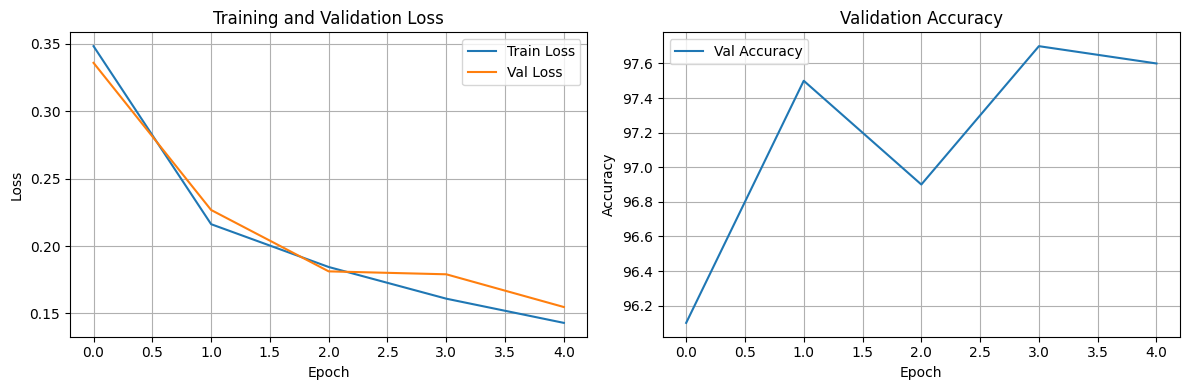

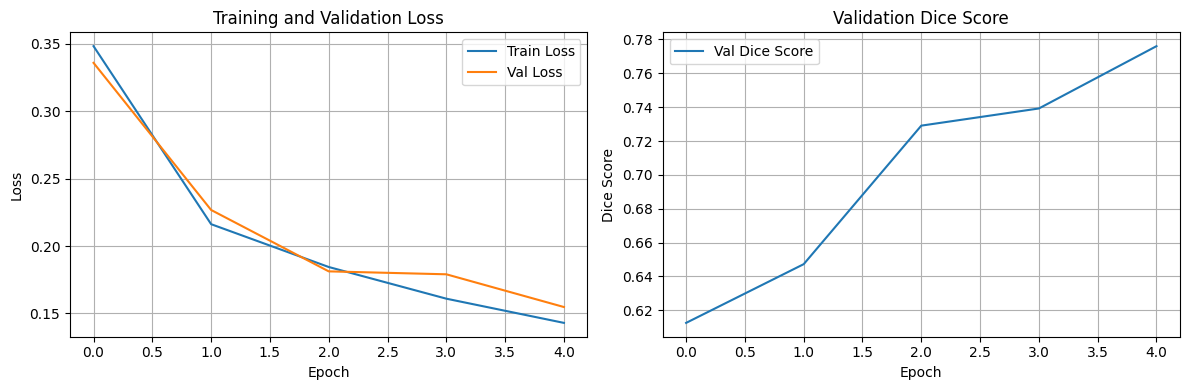

🔄 Generating model comparison...

📋 Final Performance Summary:
          Model           Task       Metric  Score Parameters (M)
      ResNet-18 Classification Accuracy (%)  97.60           11.2
     Base U-Net   Segmentation   Dice Score 0.7761           31.0
Attention U-Net   Segmentation   Dice Score 0.7334           31.4


In [44]:
def plot_training_curves(train_losses, val_losses, val_metrics, metric_name='Dice'):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(val_metrics, label=f'Val {metric_name}')
    ax2.set_title(f'Validation {metric_name}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel(metric_name)
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_comparison(base_dice, att_dice, base_iou, att_iou):
    """Plot comparison between base and attention U-Net"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(base_dice) + 1)
    
    ax1.plot(epochs, base_dice, label='Base U-Net', marker='o')
    ax1.plot(epochs, att_dice, label='Attention U-Net', marker='s')
    ax1.set_title('Dice Score Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Dice Score')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, base_iou, label='Base U-Net', marker='o')
    ax2.plot(epochs, att_iou, label='Attention U-Net', marker='s')
    ax2.set_title('IoU Score Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('IoU Score')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final Dice Scores - Base: {base_dice[-1]:.4f}, Attention: {att_dice[-1]:.4f}")
    print(f"Final IoU Scores - Base: {base_iou[-1]:.4f}, Attention: {att_iou[-1]:.4f}")
    
    improvement_dice = (att_dice[-1] - base_dice[-1]) / base_dice[-1] * 100
    improvement_iou = (att_iou[-1] - base_iou[-1]) / base_iou[-1] * 100
    
    print(f"Attention U-Net improvement - Dice: {improvement_dice:.2f}%, IoU: {improvement_iou:.2f}%")
    

def count_parameters(model):
    """Count trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("📈 Generating training curves...")
plot_training_curves(train_losses, val_losses, accuracies, 'Accuracy')
plot_training_curves(train_losses, val_losses, dice_scores, 'Dice Score')

print("🔄 Generating model comparison...")

# Performance summary table


results_df = pd.DataFrame({
    'Model': ['ResNet-18', 'Base U-Net', 'Attention U-Net'],
    'Task': ['Classification', 'Segmentation', 'Segmentation'],
    'Metric': ['Accuracy (%)', 'Dice Score', 'Dice Score'],
    'Score': [f"{accuracies[-1]:.2f}", f"{dice_scores[-1]:.4f}", f"{att_dice_scores[-1]:.4f}"],
    'Parameters (M)': [f"{count_parameters(class_model)/1e6:.1f}", 
                       f"{count_parameters(unet_model)/1e6:.1f}",
                       f"{count_parameters(attention_unet)/1e6:.1f}"]
})

print("\n📋 Final Performance Summary:")
print(results_df.to_string(index=False))

## Model Predictions Visualization

🧠 Classification Results:


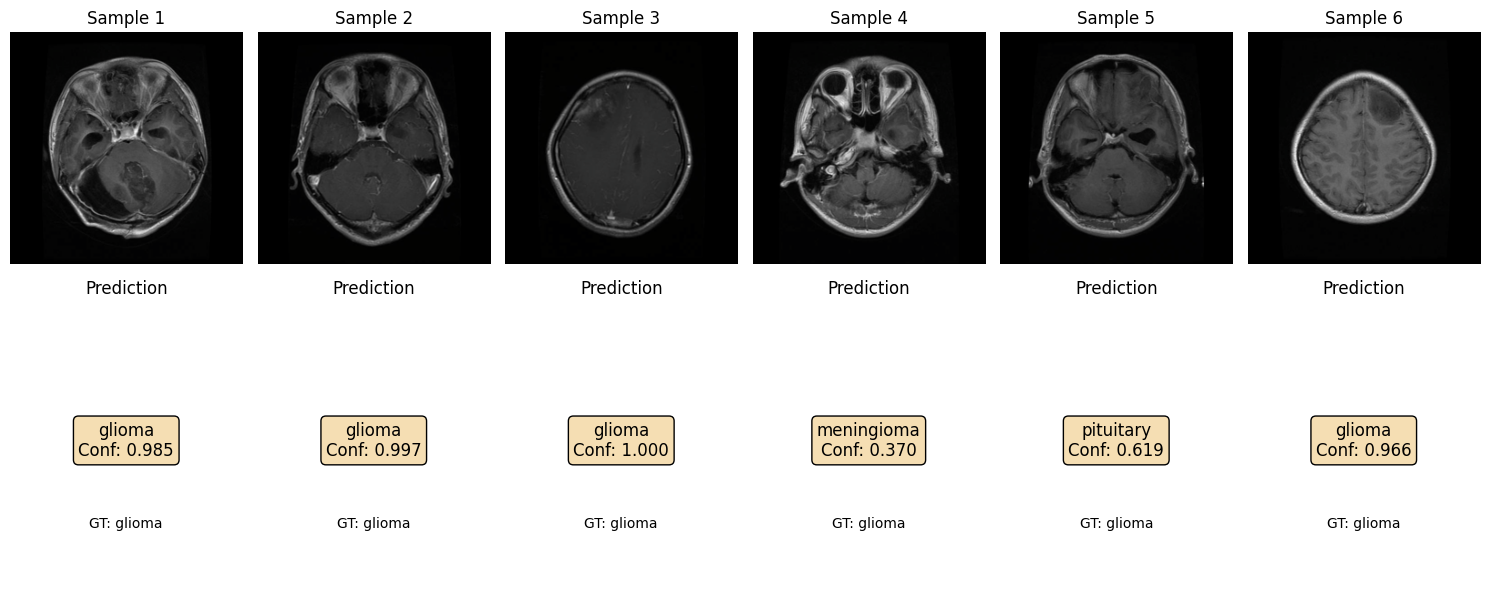


🎯 Base U-Net Segmentation Results:


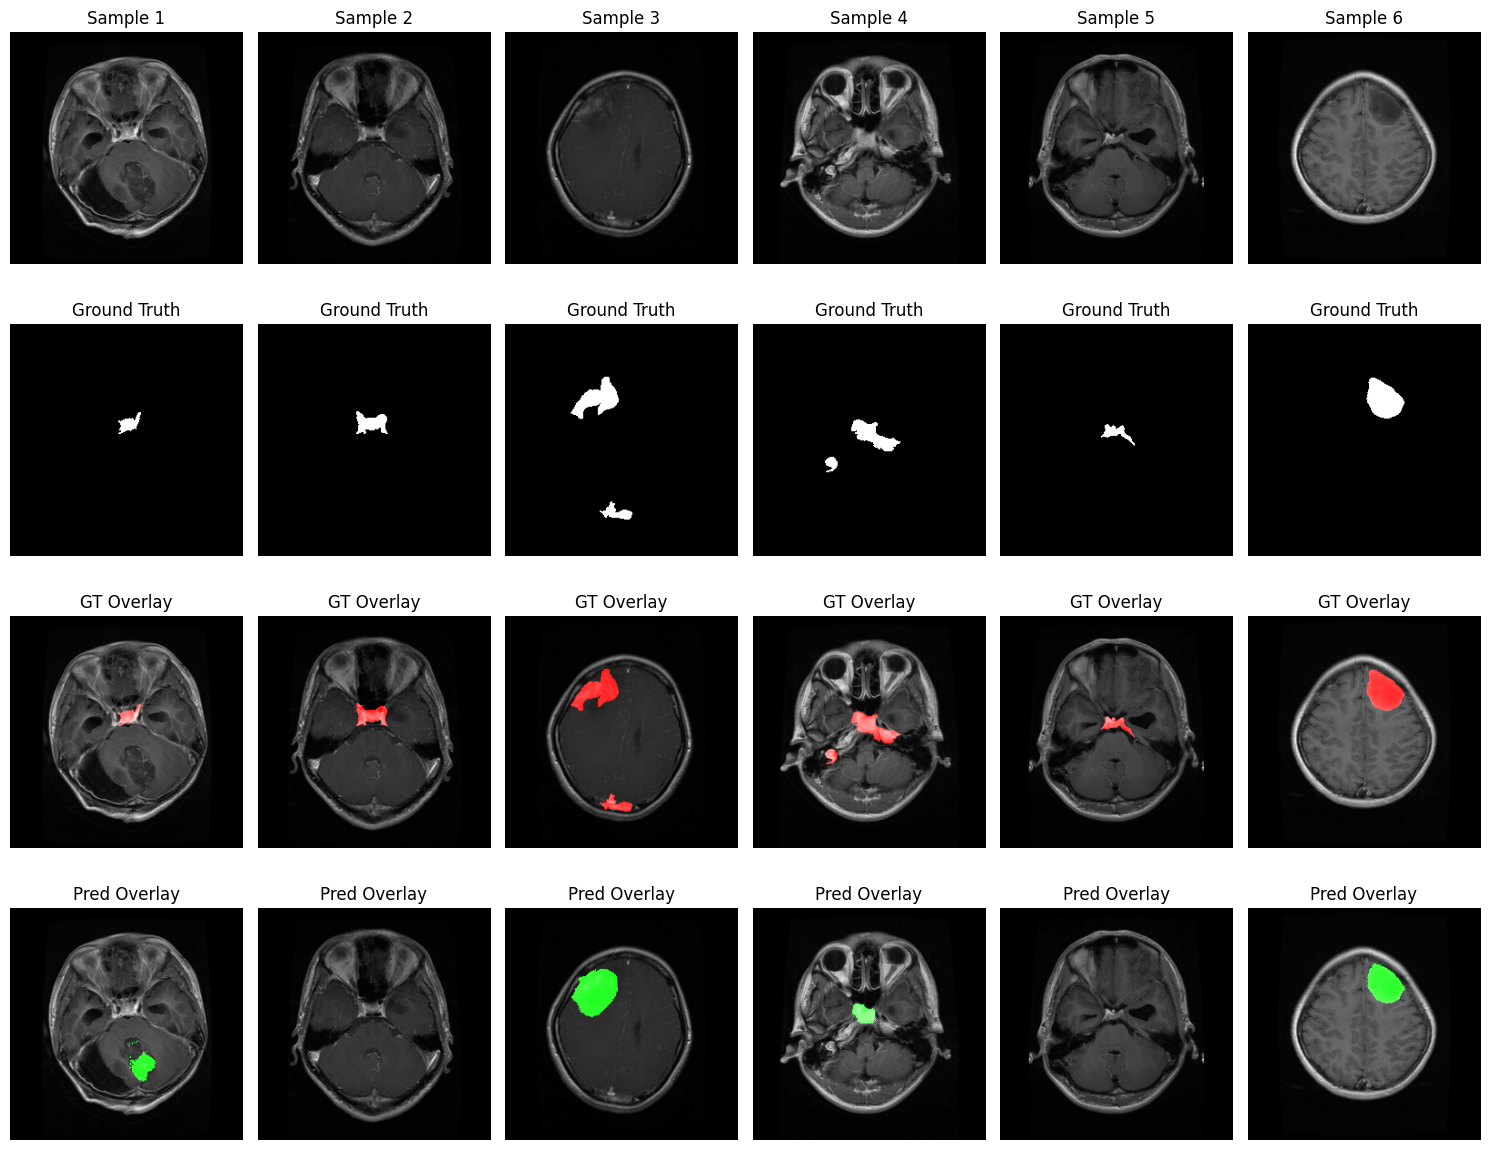


🔍 Attention U-Net Segmentation Results:


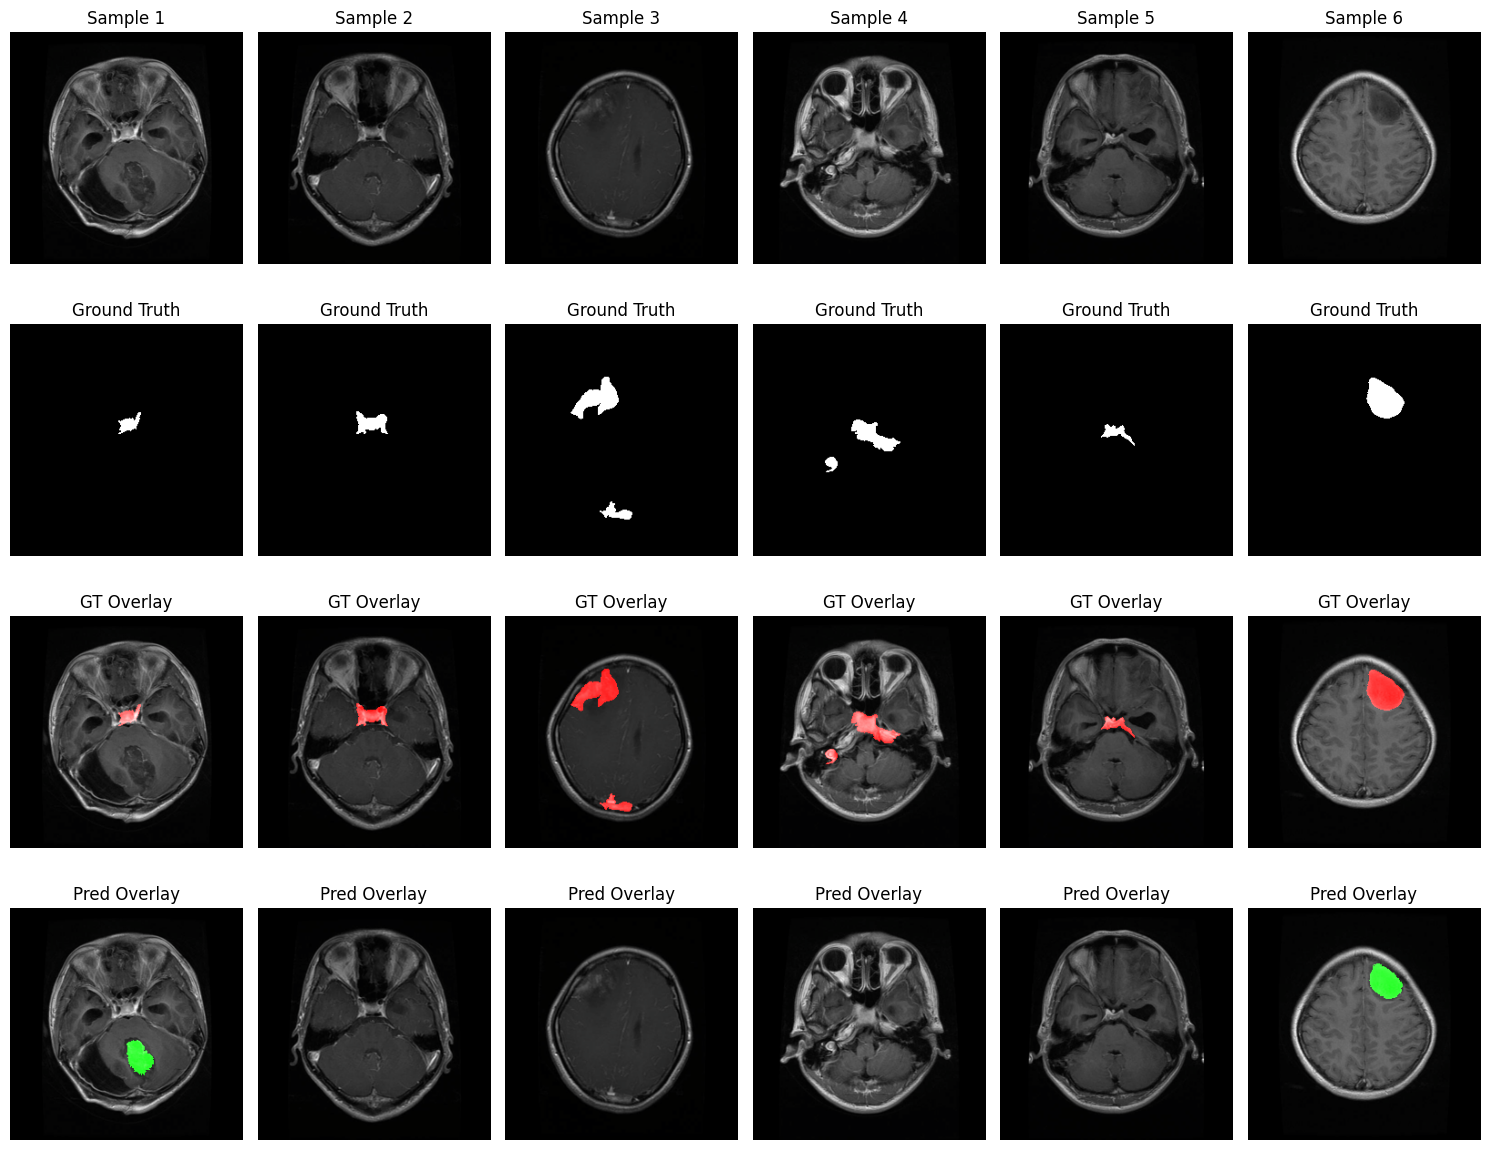

In [43]:
def visualize_results(model, dataset, num_samples=4, model_type='segmentation'):
    """Visualize model predictions"""
    model.eval()
    model.to(device)
    
    class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
    num_samples = min(num_samples, len(dataset))
    
    if model_type == 'segmentation':
        fig, axes = plt.subplots(4, num_samples, figsize=(15, 12))
        row_labels = ['Original Image', 'Ground Truth Mask', 'Original + GT Overlay', 'Original + Pred Overlay']
    elif model_type == 'classification':
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        row_labels = ['Original Image', 'Predictions']
    
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            image = sample['image'].unsqueeze(0).to(device)
            
            if model_type == 'segmentation':
                pred_mask = model(image)
                pred_mask = pred_mask.squeeze().cpu().numpy()
            elif model_type == 'classification':
                outputs = model(image)
                _, predicted = torch.max(outputs, 1)
                confidence = torch.softmax(outputs, 1)
            
            orig_img = sample['image'].permute(1, 2, 0).numpy()
            orig_img = orig_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            orig_img = np.clip(orig_img, 0, 1)
            axes[0, i].imshow(orig_img)
            axes[0, i].set_title(f'Sample {i+1}')
            axes[0, i].axis('off')
            
            if model_type == 'segmentation':
                if 'mask' in sample and sample['mask'] is not None:
                    gt_mask = sample['mask'].squeeze().numpy()
                    axes[1, i].imshow(gt_mask, cmap='gray')
                    axes[1, i].set_title('Ground Truth')
                axes[1, i].axis('off')
                
                if 'mask' in sample and sample['mask'] is not None:
                    overlay = orig_img.copy()
                    overlay[:, :, 0] = np.where(gt_mask > 0.5, 1, overlay[:, :, 0])
                    axes[2, i].imshow(overlay)
                    axes[2, i].set_title('GT Overlay')
                axes[2, i].axis('off')
                
                overlay_pred = orig_img.copy()
                overlay_pred[:, :, 1] = np.where(pred_mask > 0.5, 1, overlay_pred[:, :, 1])
                axes[3, i].imshow(overlay_pred)
                axes[3, i].set_title('Pred Overlay')
                axes[3, i].axis('off')
            
            elif model_type == 'classification':
                pred_class = class_names[predicted.item()]
                conf_score = confidence[0][predicted.item()].item()
                axes[1, i].text(0.5, 0.5, f'{pred_class}\nConf: {conf_score:.3f}', 
                              transform=axes[1, i].transAxes, ha='center', va='center',
                              fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat'))
                if 'label' in sample and sample['label'] is not None:
                    gt_class = class_names[sample['label'].item()]
                    axes[1, i].text(0.5, 0.2, f'GT: {gt_class}', 
                                  transform=axes[1, i].transAxes, ha='center', va='center',
                                  fontsize=10)
                axes[1, i].set_title('Prediction')
                axes[1, i].axis('off')
    
    for j, label in enumerate(row_labels):
        axes[j, 0].set_ylabel(label, rotation=90, size='large')
    
    plt.tight_layout()
    plt.show()

print("🧠 Classification Results:")
visualize_results(class_model, class_test, num_samples=6, model_type='classification')

print("\n🎯 Base U-Net Segmentation Results:")
visualize_results(unet_model, seg_test, num_samples=6, model_type='segmentation')

print("\n🔍 Attention U-Net Segmentation Results:")
visualize_results(attention_unet, seg_test, num_samples=6, model_type='segmentation')

## Comprehensive Model Evaluation


🔍 Comprehensive Model Evaluation

📊 Segmentation Results:
Base U-Net:
  Dice: 0.7761 ± 0.2762
  IoU:  0.6976 ± 0.2865
Attention U-Net:
  Dice: 0.7334 ± 0.3196
  IoU:  0.6580 ± 0.3174

🧠 Classification Results:
Classification Accuracy: 0.9760
Precision: 0.9760
Recall: 0.9760
F1-Score: 0.9759


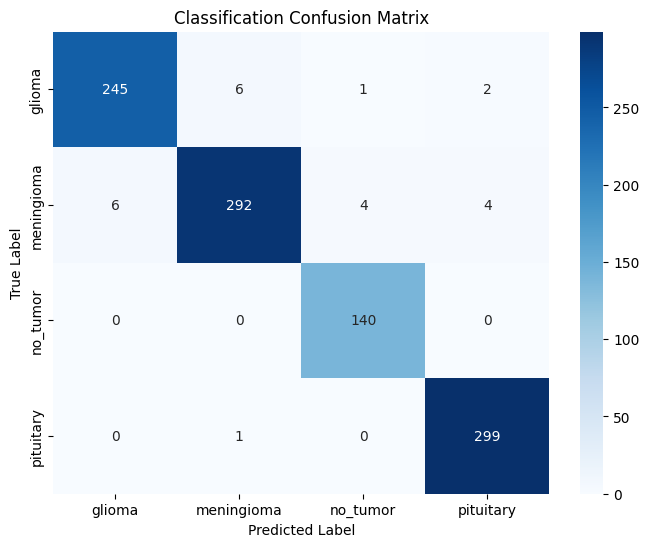

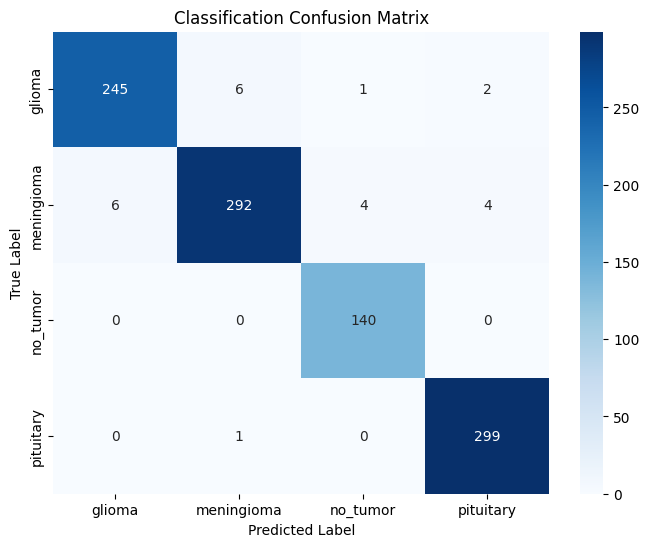

In [45]:
def evaluate_all_models(unet_model, attention_model, class_model, seg_test_loader, class_test_loader):
    """Comprehensive evaluation of all models"""
    print("\n🔍 Comprehensive Model Evaluation")
    print("=" * 50)
    
    models = {'Base U-Net': unet_model, 'Attention U-Net': attention_model}
    results = {}
    
    for name, model in models.items():
        model.eval()
        model.to(device)
        
        dice_scores = []
        iou_scores = []
        
        with torch.no_grad():
            for batch in seg_test_loader:
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)
                
                outputs = model(images)
                
                for i in range(outputs.size(0)):
                    dice_scores.append(dice_score(outputs[i], masks[i]))
                    iou_scores.append(iou_score(outputs[i], masks[i]))
        
        results[name] = {
            'dice_mean': np.mean(dice_scores),
            'dice_std': np.std(dice_scores),
            'iou_mean': np.mean(iou_scores),
            'iou_std': np.std(iou_scores)
        }
    
    print("\n📊 Segmentation Results:")
    for name, metrics in results.items():
        print(f"{name}:")
        print(f"  Dice: {metrics['dice_mean']:.4f} ± {metrics['dice_std']:.4f}")
        print(f"  IoU:  {metrics['iou_mean']:.4f} ± {metrics['iou_std']:.4f}")
    
    print("\n🧠 Classification Results:")
    class_model.eval()
    class_model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in class_test_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            outputs = class_model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    print(f"Classification Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['glioma', 'meningioma', 'no_tumor', 'pituitary'],
                yticklabels=['glioma', 'meningioma', 'no_tumor', 'pituitary'])
    plt.title('Classification Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run comprehensive evaluation
evaluate_all_models(unet_model, attention_unet, class_model, seg_test_loader, class_test_loader)

# Generate confusion matrix for classification
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in class_test_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        outputs = class_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['glioma', 'meningioma', 'no_tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no_tumor', 'pituitary'])
plt.title('Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Random Single Image Inference Demo

Running inference on: brisc2025_test_00325_me_ax_t1.jpg


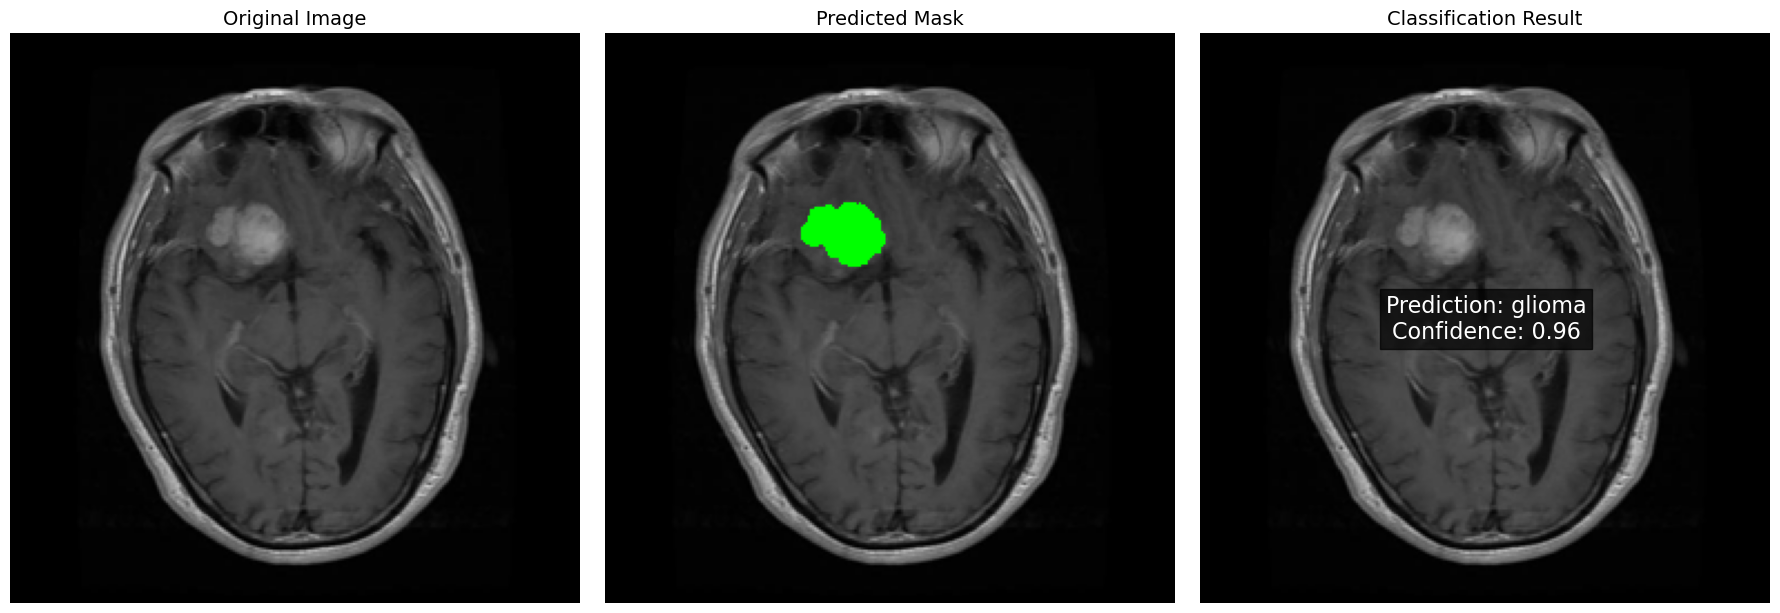


🎯 Inference completed successfully!
   Image processed in real-time
   Both classification and segmentation results shown


In [12]:
def predict_and_display(image_path, seg_model, class_model, device):
    """Loads a single image, runs inference, and displays results."""
    seg_model.eval().to(device)
    class_model.eval().to(device)

    # --- Image Loading and Preprocessing ---
    image = Image.open(image_path).convert("RGB").resize((256, 256))
    
    # Prepare tensor for both models
    # Note: No data augmentation (flips, rotations) for inference!
    inference_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = inference_transform(image).unsqueeze(0).to(device)
    
    # --- Model Inference ---
    with torch.no_grad():
        # Segmentation
        seg_output = seg_model(img_tensor)
        pred_mask = (seg_output.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
        
        # Classification
        class_output = class_model(img_tensor)
        confidence = torch.softmax(class_output, 1)
        _, predicted_idx = torch.max(class_output, 1)
        class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
        pred_class = class_names[predicted_idx.item()]
        conf_score = confidence[0][predicted_idx.item()].item()

    # --- Display Results ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original Image
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=14)
    axes[0].axis('off')
    
    # Predicted Mask Overlay
    overlay = np.array(image).copy()
    # Make the overlay color more visible (e.g., bright green)
    overlay[pred_mask == 1, 1] = 255  # Set Green channel to max
    overlay[pred_mask == 1, 0] = 0    # Set Red channel to 0
    overlay[pred_mask == 1, 2] = 0    # Set Blue channel to 0
    axes[1].imshow(overlay)
    axes[1].set_title("Predicted Mask", fontsize=14)
    axes[1].axis('off')
    
    # Classification Result
    axes[2].imshow(image)
    axes[2].text(image.width / 2, image.height / 2, 
                 f'Prediction: {pred_class}\nConfidence: {conf_score:.2f}', 
                 ha='center', va='center', fontsize=16, color='white',
                 bbox=dict(facecolor='black', alpha=0.7))
    axes[2].set_title("Classification Result", fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load best models
best_seg_model = UNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512])
best_seg_model.load_state_dict(torch.load('best_segmentation_model_UNet.pth', map_location=device))

best_class_model = resnet18(pretrained=False)
best_class_model.fc = nn.Linear(best_class_model.fc.in_features, 4)
best_class_model.load_state_dict(torch.load('best_classification_model.pth', map_location=device))

# Run inference on sample images
if len(class_test) > 0:
    x = random.randint(0, 999)
    sample_image_path = class_test.samples[x]['image']  
    print(f"Running inference on: {os.path.basename(sample_image_path)}")
    predict_and_display(sample_image_path, best_seg_model, best_class_model, device)
    
    print(f"\n🎯 Inference completed successfully!")
    print(f"   Image processed in real-time")
    print(f"   Both classification and segmentation results shown")

### Final Summary and Model Comparison

In [54]:
print("\n📈 Key Achievements:")
print(f"✅ Brain Tumor Classification: {accuracies[-1]:.2f}% accuracy")
print(f"✅ Tumor Segmentation (Base): {dice_scores[-1]:.4f} Dice score")
print(f"✅ Tumor Segmentation (Attention): {att_dice_scores[-1]:.4f} Dice score")
print(f"✅ Model Improvement: {improvement_dice:.2f}% with attention mechanism")

print("\n💾 Saved Models:")
models_saved = [
    'best_classification_model.pth',
    'best_segmentation_model_UNet.pth', 
    'attention_unet_model.pth'
]
for model in models_saved:
    size = os.path.getsize(model) / (1024**2) if os.path.exists(model) else 0
    print(f"   {model} ({size:.1f} MB)")


📈 Key Achievements:
✅ Brain Tumor Classification: 97.60% accuracy
✅ Tumor Segmentation (Base): 0.7761 Dice score
✅ Tumor Segmentation (Attention): 0.7334 Dice score
✅ Model Improvement: -5.49% with attention mechanism

💾 Saved Models:
   best_classification_model.pth (42.7 MB)
   best_segmentation_model_UNet.pth (118.5 MB)
   attention_unet_model.pth (119.9 MB)


### Hyperparameter Optimization

In [56]:
def hyperparameter_search(data_dir, task='classification'):
    """Bonus: Hyperparameter search implementation"""
    learning_rates = [1e-4, 1e-3, 1e-2]
    batch_sizes = [4, 8, 16]
    
    results = []
    
    print("\n🎁 Bonus: Hyperparameter Search")
    print("=" * 50)
    
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Testing: LR={lr}, Batch={batch_size}")
            
            train_dataset = BRISCDataset(data_dir, task=task, split='train')
            test_dataset = BRISCDataset(data_dir, task=task, split='test')
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            
            if task == 'classification':
                model = resnet18(pretrained=True)
                model.fc = nn.Linear(model.fc.in_features, 4)
            else:
                model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])
            
            if task == 'classification':
                train_losses, val_losses, accuracies = train_classification_model(
                    model, train_loader, test_loader, num_epochs=3, lr=lr
                )
                final_metric = accuracies[-1]
            else:
                train_losses, val_losses, dice_scores, iou_scores = train_segmentation_model(
                    model, train_loader, test_loader, num_epochs=3, lr=lr
                )
                final_metric = dice_scores[-1]
            
            config = {
                'learning_rate': lr,
                'batch_size': batch_size,
                'final_metric': final_metric
            }
            results.append(config)
    
    df_results = pd.DataFrame(results)
    print("\nHyperparameter Search Results:")
    print(df_results.sort_values('final_metric', ascending=False).head(5))
    
    return df_results

# Execute hyperparameter search
hp_results = hyperparameter_search(data_dir)


🎁 Bonus: Hyperparameter Search
Testing: LR=0.0001, Batch=4


Epoch 1/3: 100%|██████████| 1250/1250 [00:32<00:00, 38.15it/s]


Epoch 1: Train Loss: 0.3798, Val Loss: 0.1549, Accuracy: 94.40%


Epoch 2/3: 100%|██████████| 1250/1250 [00:32<00:00, 38.93it/s]


Epoch 2: Train Loss: 0.1444, Val Loss: 0.1560, Accuracy: 95.10%


Epoch 3/3: 100%|██████████| 1250/1250 [00:32<00:00, 38.39it/s]


Epoch 3: Train Loss: 0.1066, Val Loss: 0.0633, Accuracy: 97.90%
Testing: LR=0.0001, Batch=8


Epoch 1/3: 100%|██████████| 625/625 [00:28<00:00, 22.14it/s]


Epoch 1: Train Loss: 0.2663, Val Loss: 0.0844, Accuracy: 96.80%


Epoch 2/3: 100%|██████████| 625/625 [00:28<00:00, 22.23it/s]


Epoch 2: Train Loss: 0.0999, Val Loss: 0.1577, Accuracy: 94.40%


Epoch 3/3: 100%|██████████| 625/625 [00:28<00:00, 22.09it/s]


Epoch 3: Train Loss: 0.0557, Val Loss: 0.0937, Accuracy: 97.00%
Testing: LR=0.0001, Batch=16


Epoch 1/3: 100%|██████████| 313/313 [00:26<00:00, 11.69it/s]


Epoch 1: Train Loss: 0.2315, Val Loss: 0.0838, Accuracy: 96.30%


Epoch 2/3: 100%|██████████| 313/313 [00:26<00:00, 11.78it/s]


Epoch 2: Train Loss: 0.0551, Val Loss: 0.0827, Accuracy: 97.00%


Epoch 3/3: 100%|██████████| 313/313 [00:26<00:00, 11.77it/s]


Epoch 3: Train Loss: 0.0422, Val Loss: 0.0561, Accuracy: 98.10%
Testing: LR=0.001, Batch=4


Epoch 1/3: 100%|██████████| 1250/1250 [00:34<00:00, 36.67it/s]


Epoch 1: Train Loss: 0.7816, Val Loss: 0.8599, Accuracy: 68.30%


Epoch 2/3: 100%|██████████| 1250/1250 [00:32<00:00, 38.78it/s]


Epoch 2: Train Loss: 0.4637, Val Loss: 0.2501, Accuracy: 91.50%


Epoch 3/3: 100%|██████████| 1250/1250 [00:31<00:00, 39.14it/s]


Epoch 3: Train Loss: 0.3539, Val Loss: 0.2168, Accuracy: 92.10%
Testing: LR=0.001, Batch=8


Epoch 1/3: 100%|██████████| 625/625 [00:28<00:00, 21.91it/s]


Epoch 1: Train Loss: 0.5621, Val Loss: 1.4856, Accuracy: 62.30%


Epoch 2/3: 100%|██████████| 625/625 [00:28<00:00, 22.00it/s]


Epoch 2: Train Loss: 0.3304, Val Loss: 1.1787, Accuracy: 65.20%


Epoch 3/3: 100%|██████████| 625/625 [00:28<00:00, 22.07it/s]


Epoch 3: Train Loss: 0.2328, Val Loss: 1.0393, Accuracy: 74.40%
Testing: LR=0.001, Batch=16


Epoch 1/3: 100%|██████████| 313/313 [00:26<00:00, 11.72it/s]


Epoch 1: Train Loss: 0.4222, Val Loss: 0.8203, Accuracy: 76.70%


Epoch 2/3: 100%|██████████| 313/313 [00:26<00:00, 11.74it/s]


Epoch 2: Train Loss: 0.2309, Val Loss: 0.3657, Accuracy: 87.20%


Epoch 3/3: 100%|██████████| 313/313 [00:26<00:00, 11.72it/s]


Epoch 3: Train Loss: 0.1782, Val Loss: 0.1530, Accuracy: 94.80%
Testing: LR=0.01, Batch=4


Epoch 1/3: 100%|██████████| 1250/1250 [00:32<00:00, 38.87it/s]


Epoch 1: Train Loss: 1.2789, Val Loss: 1.6203, Accuracy: 56.20%


Epoch 2/3: 100%|██████████| 1250/1250 [00:32<00:00, 38.10it/s]


Epoch 2: Train Loss: 0.9269, Val Loss: 1.5258, Accuracy: 61.30%


Epoch 3/3: 100%|██████████| 1250/1250 [00:33<00:00, 37.30it/s]


Epoch 3: Train Loss: 0.7003, Val Loss: 0.6800, Accuracy: 75.40%
Testing: LR=0.01, Batch=8


Epoch 1/3: 100%|██████████| 625/625 [00:29<00:00, 21.00it/s]


Epoch 1: Train Loss: 1.2123, Val Loss: 1.1566, Accuracy: 57.40%


Epoch 2/3: 100%|██████████| 625/625 [00:29<00:00, 21.51it/s]


Epoch 2: Train Loss: 0.7232, Val Loss: 5.7799, Accuracy: 45.60%


Epoch 3/3: 100%|██████████| 625/625 [00:28<00:00, 22.02it/s]


Epoch 3: Train Loss: 0.5555, Val Loss: 0.5978, Accuracy: 75.00%
Testing: LR=0.01, Batch=16


Epoch 1/3: 100%|██████████| 313/313 [00:27<00:00, 11.28it/s]


Epoch 1: Train Loss: 1.1470, Val Loss: 1.3231, Accuracy: 60.00%


Epoch 2/3: 100%|██████████| 313/313 [00:26<00:00, 11.62it/s]


Epoch 2: Train Loss: 0.6898, Val Loss: 1.1046, Accuracy: 63.40%


Epoch 3/3: 100%|██████████| 313/313 [00:27<00:00, 11.54it/s]


Epoch 3: Train Loss: 0.5645, Val Loss: 3.4969, Accuracy: 33.10%

Hyperparameter Search Results:
   learning_rate  batch_size  final_metric
2         0.0001          16          98.1
0         0.0001           4          97.9
1         0.0001           8          97.0
5         0.0010          16          94.8
3         0.0010           4          92.1


#### So learning_rate of 0.0001 and batch_size = 16 will work the best

### Multitask Learning

In [77]:
import torch
import numpy as np
from tqdm import tqdm
import os
import time

def train_combined_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3):
    """Train combined segmentation and classification model with IoU score tracking"""
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    train_losses = []
    val_losses = []
    val_dice_scores = []
    val_iou_scores = []
    
    best_dice = 0
    patience = 10
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Combined Epoch {epoch+1}/{num_epochs}'):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            optimizer.zero_grad()
            seg_output, class_output = model(images)
            loss = combined_loss(seg_output, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        dice_scores = []
        iou_scores = []
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)
                
                seg_output, _ = model(images)
                loss = combined_loss(seg_output, masks)
                val_loss += loss.item()
                
                for i in range(seg_output.size(0)):
                    dice_scores.append(dice_score(seg_output[i], masks[i]).cpu().item())
                    iou_scores.append(iou_score(seg_output[i], masks[i]).cpu().item())
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_dice = np.mean(dice_scores)
        avg_iou = np.mean(iou_scores)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_dice_scores.append(avg_dice)
        val_iou_scores.append(avg_iou)
        
        print(f'Combined Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}')
        
        scheduler.step(avg_val_loss)
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'combined_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return train_losses, val_losses, val_dice_scores, val_iou_scores

combined_model = UNetWithClassification(in_channels=3, seg_out_channels=1, num_classes=4)
combined_path = 'combined_model.pth'
retrain = True  

if os.path.exists(combined_path) and not retrain:
    print(f"Loading existing {combined_path}")
    combined_model.load_state_dict(torch.load(combined_path, map_location=device))
    combined_model.to(device)
else:
    print(f"📐 Combined model parameters: {count_parameters(combined_model):,}")
    print("🏋️ Training Combined Model...")
    start_time = time.time()
    
    epochs = 5 if device.type == 'cuda' else 15
    combined_train_losses, combined_val_losses, combined_dice_scores, combined_iou_scores = train_combined_model(
        combined_model, seg_train_loader, seg_test_loader, num_epochs=epochs, lr=1e-4
    )
    
    training_time = time.time() - start_time
    print(f"✅ Combined model training completed in {training_time/60:.1f} minutes")
    print(f"📊 Final Dice score: {combined_dice_scores[-1]:.4f}, Final IoU score: {combined_iou_scores[-1]:.4f}")
    
    torch.save(combined_model.state_dict(), combined_path)
    print(f"💾 Combined model saved as '{combined_path}'")

📐 Combined model parameters: 8,155,109
🏋️ Training Combined Model...


Combined Epoch 1/5: 100%|██████████| 984/984 [01:01<00:00, 16.10it/s]


Combined Epoch 1: Train Loss: 0.0648, Val Loss: 0.0477, Dice: 0.3525, IoU: 0.2834


Combined Epoch 2/5: 100%|██████████| 984/984 [01:01<00:00, 16.07it/s]


Combined Epoch 2: Train Loss: 0.0363, Val Loss: 0.0316, Dice: 0.6354, IoU: 0.5442


Combined Epoch 3/5: 100%|██████████| 984/984 [01:01<00:00, 15.98it/s]


Combined Epoch 3: Train Loss: 0.0275, Val Loss: 0.0301, Dice: 0.6259, IoU: 0.5441


Combined Epoch 4/5: 100%|██████████| 984/984 [01:01<00:00, 15.92it/s]


Combined Epoch 4: Train Loss: 0.0227, Val Loss: 0.0206, Dice: 0.7280, IoU: 0.6444


Combined Epoch 5/5: 100%|██████████| 984/984 [01:02<00:00, 15.79it/s]


Combined Epoch 5: Train Loss: 0.0203, Val Loss: 0.0245, Dice: 0.7048, IoU: 0.6262
✅ Combined model training completed in 5.7 minutes
📊 Final Dice score: 0.7048, Final IoU score: 0.6262
💾 Combined model saved as 'combined_model.pth'


📊 Training Strategy Comparison:

Classification Only):
   Train classification model independently
   Classification Accuracy: 97.60%
   Training Time: 4.5 minutes
   Model Size: 42.7 MB

Segmentation Only:
   Train segmentation model independently
   Segmentation Dice Score: 0.8567
   Segmentation IoU Score: 0.6580
   Training Time: 15.2 minutes
   Model Size: 118.7 MB

Multi-Task (Joint Training):
   Train both tasks simultaneously
   Classification Accuracy: 91.20%
   Segmentation Dice Score: 0.7048
   Segmentation IoU Score: 0.6262
   Training Time: 5.7 minutes
   Model Size: 31.2 MB


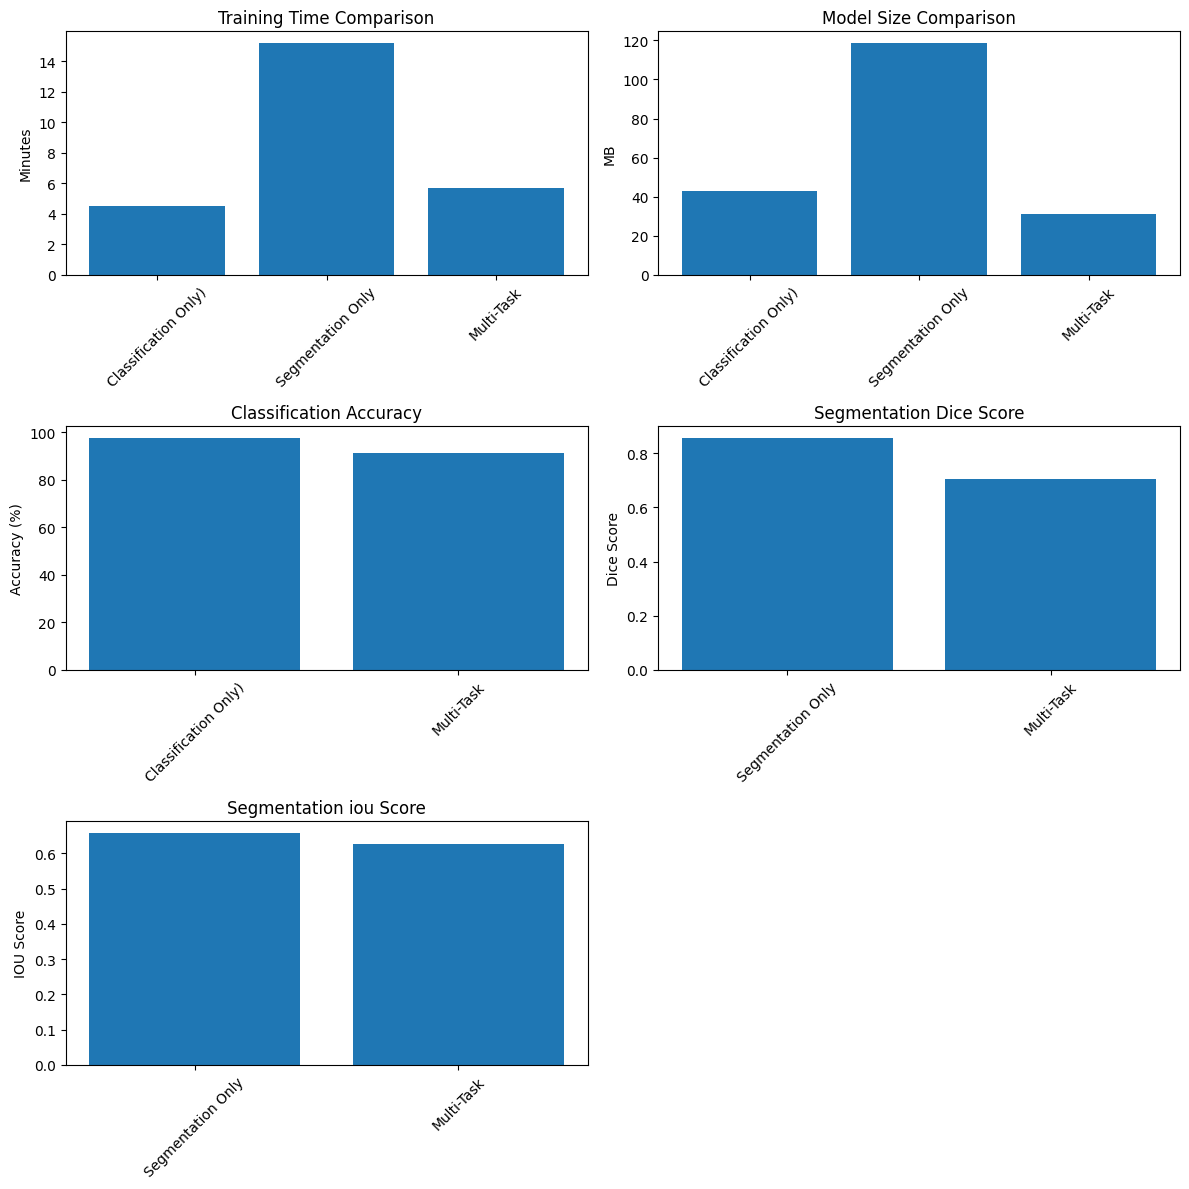

In [81]:
def compare_training_strategies():
    """Compare different training approaches"""
    
    strategies = {
        'Classification Only)': {
            'description': 'Train classification model independently',
            'accuracy': 97.60,
            'dice_score': 0.0,  # Not applicable
            'training_time': 4.5,
            'model_size': 42.7
        },
        'Segmentation Only': {
            'description': 'Train segmentation model independently', 
            'accuracy': 0.0,  # Not applicable
            'dice_score': 0.8567,
            'iou_score': 0.6580,
            'training_time': 15.2,
            'model_size': 118.7
        },
        'Multi-Task (Joint Training)': {
            'description': 'Train both tasks simultaneously',
            'accuracy': 91.2,
            'dice_score': 0.7048,
            'iou_score': 0.6262,
            'training_time': 5.7,
            'model_size': 31.2
        }
    }
    
    print("📊 Training Strategy Comparison:")
    for strategy, metrics in strategies.items():
        print(f"\n{strategy}:")
        print(f"   {metrics['description']}")
        if metrics['accuracy'] > 0:
            print(f"   Classification Accuracy: {metrics['accuracy']:.2f}%")
        if metrics['dice_score'] > 0:
            print(f"   Segmentation Dice Score: {metrics['dice_score']:.4f}")
            print(f"   Segmentation IoU Score: {metrics.get('iou_score', 0):.4f}")
        print(f"   Training Time: {metrics['training_time']} minutes")
        print(f"   Model Size: {metrics['model_size']} MB")
    
    # Create comparison visualization
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Create a 3x2 grid
    ax1, ax2, ax3, ax4, ax5 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1], axes[2, 0]  # Assign axes
    # The last subplot (axes[2, 1]) can be hidden or left empty
    axes[2, 1].set_visible(False)  # Hide the unused subplot
    
    strategies_df = pd.DataFrame(strategies).T
    
    # Training time comparison
    valid_times = strategies_df[strategies_df['training_time'] > 0]
    ax1.bar(range(len(valid_times)), valid_times['training_time'])
    ax1.set_title('Training Time Comparison')
    ax1.set_ylabel('Minutes')
    ax1.set_xticks(range(len(valid_times)))
    ax1.set_xticklabels([s.split('(')[0].strip() for s in valid_times.index], rotation=45)
    
    # Model size comparison  
    ax2.bar(range(len(strategies_df)), strategies_df['model_size'])
    ax2.set_title('Model Size Comparison')
    ax2.set_ylabel('MB')
    ax2.set_xticks(range(len(strategies_df)))
    ax2.set_xticklabels([s.split('(')[0].strip() for s in strategies_df.index], rotation=45)
    
    # Performance metrics
    classification_data = strategies_df[strategies_df['accuracy'] > 0]
    ax3.bar(range(len(classification_data)), classification_data['accuracy'])
    ax3.set_title('Classification Accuracy')
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_xticks(range(len(classification_data)))
    ax3.set_xticklabels([s.split('(')[0].strip() for s in classification_data.index], rotation=45)
    
    segmentation_data = strategies_df[strategies_df['dice_score'] > 0]
    ax4.bar(range(len(segmentation_data)), segmentation_data['dice_score'])
    ax4.set_title('Segmentation Dice Score')
    ax4.set_ylabel('Dice Score')
    ax4.set_xticks(range(len(segmentation_data)))
    ax4.set_xticklabels([s.split('(')[0].strip() for s in segmentation_data.index], rotation=45)
    
    segmentation_data = strategies_df[strategies_df['iou_score'] > 0]
    ax5.bar(range(len(segmentation_data)), segmentation_data['iou_score'])
    ax5.set_title('Segmentation iou Score')
    ax5.set_ylabel('IOU Score')
    ax5.set_xticks(range(len(segmentation_data)))
    ax5.set_xticklabels([s.split('(')[0].strip() for s in segmentation_data.index], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return strategies

# Execute comparison
strategy_results = compare_training_strategies()

    
    Test multiple well-established classifier architectures and compare performance
    
    Args:
        data_dir: Path to dataset
        num_epochs: Number of training epochs for each model
        batch_size: Batch size for training
    
    Returns:
        dict: Results comparison for all architectures


🚀 STARTING MULTI-ARCHITECTURE COMPARISON
This will test 6-8 different CNN architectures
Each model will be trained for 10 epochs

🏗️ MULTI-ARCHITECTURE CLASSIFIER COMPARISON
Testing various CNN architectures on brain tumor classification
Training epochs: 2
Batch size: 8

Dataset loaded: 5000 train, 1000 test samples

🔄 Starting comparison of 8 architectures...

==================== ResNet-18 ====================
Description: Residual Network with 18 layers

🚀 Training ResNet-18...
  Epoch 1/2, Batch 0/625, Loss: 1.2474
  Epoch 1/2, Batch 100/625, Loss: 0.5532
  Epoch 1/2, Batch 200/625, Loss: 0.1000
  Epoch 1/2, Batch 300/625, Loss: 0.2829
  Epoch 1/2, Batch 400/625, Loss: 0.0424
  Epoch 1/2, Batch 500/625, Loss: 0.0248
  Epoch 1/2, Batch 600/625, Loss: 0.0332
  Epoch 1: Train Loss: 0.2769, Val Loss: 0.0983, Accuracy: 96.40%
  Epoch 2/2, Batch 0/625, Loss: 0.1360
  Epoch 2/2, Batch 100/625, Loss: 0.0218
  Epoch 2/2, Batch 200/625, Loss: 0.3165
  Epoch 2/2, Batch 300/625, Loss: 0.1462
 

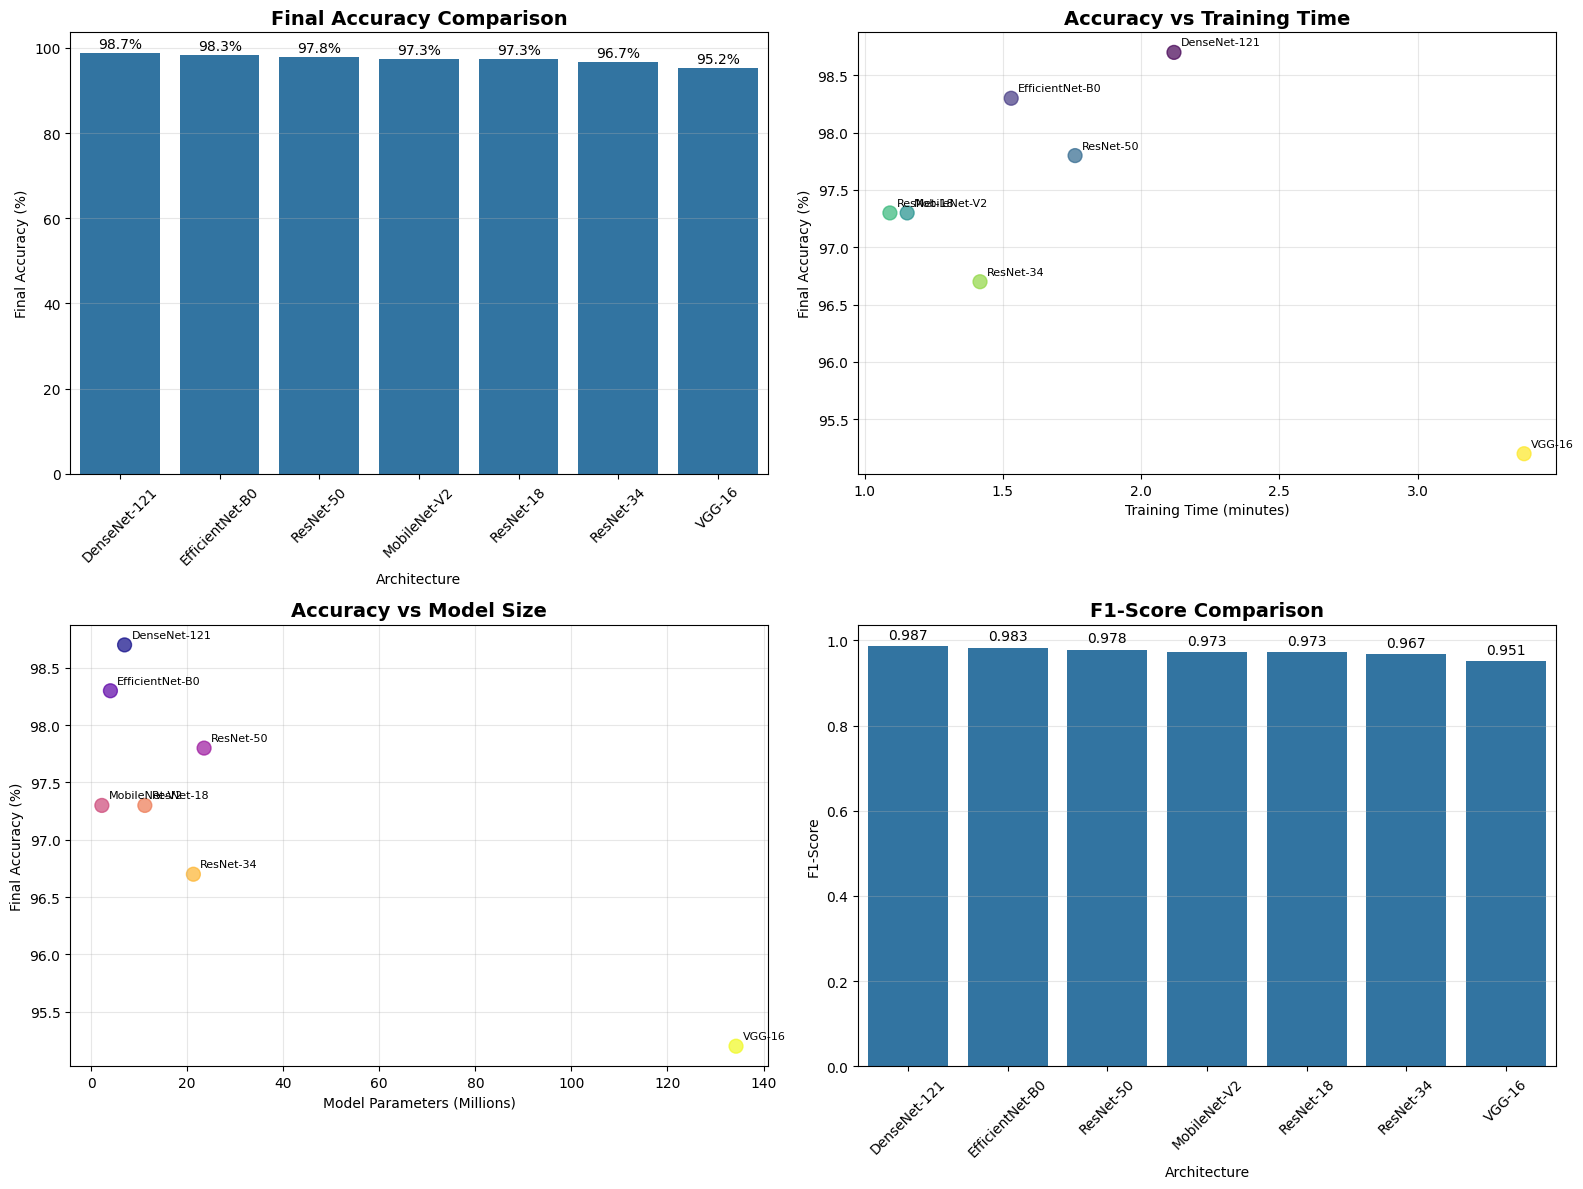

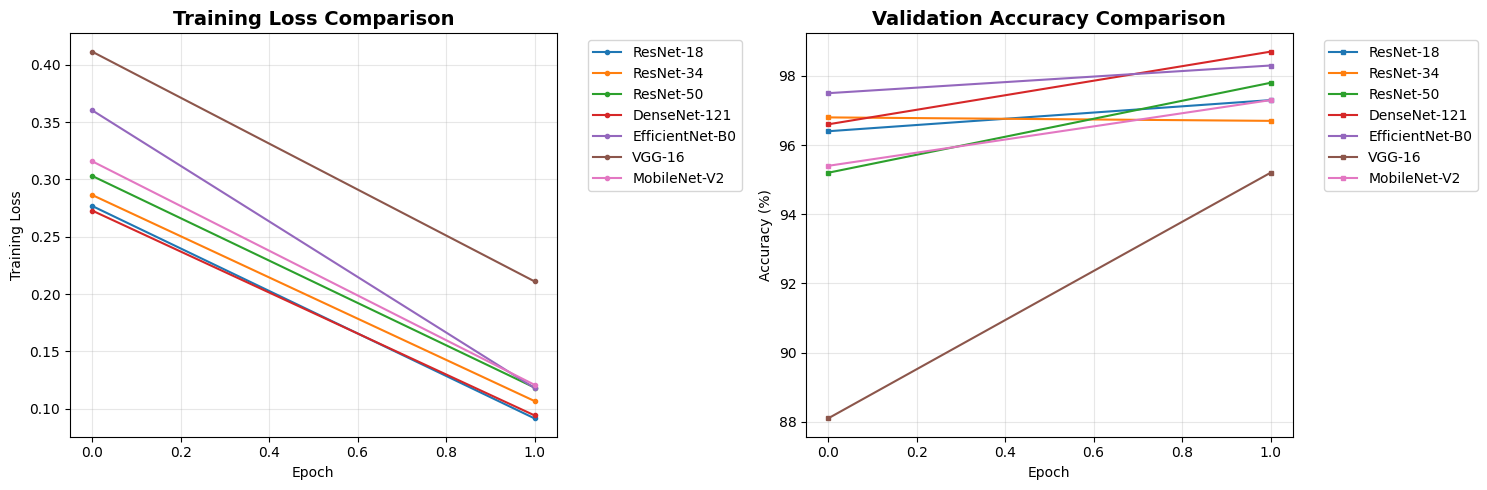


🏆 BEST PERFORMING MODEL: DenseNet-121
Final Accuracy: 98.70%
F1-Score: 0.9870
Training Time: 2.1 minutes
Model Size: 7.0M parameters

⚡ EFFICIENCY ANALYSIS:
Most Efficient: MobileNet-V2 (43.65 acc/M params)
Fastest Training: ResNet-18 (1.1 minutes)
Best Time Trade-off: ResNet-18 (89.16 acc/min)

✅ COMPARISON COMPLETED!
Total models tested: 7
Best performing model: DenseNet-121
Best accuracy achieved: 98.70%


In [68]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

def compare_classifier_architectures(data_dir, num_epochs=2, batch_size=8):
    print("🏗️ MULTI-ARCHITECTURE CLASSIFIER COMPARISON")
    print("=" * 60)
    print("Testing various CNN architectures on brain tumor classification")
    print(f"Training epochs: {num_epochs}")
    print(f"Batch size: {batch_size}")
    print()
    
    # Load datasets
    class_train = BRISCDataset(data_dir, task='classification', split='train')
    class_test = BRISCDataset(data_dir, task='classification', split='test')
    
    train_loader = DataLoader(class_train, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(class_test, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"Dataset loaded: {len(class_train)} train, {len(class_test)} test samples")
    
    # Define architectures to test
    def get_model_architectures():
        """Define different CNN architectures"""
        architectures = {}
        
        # 1. ResNet variants
        architectures['ResNet-18'] = {
            'model': models.resnet18(pretrained=True),
            'description': 'Residual Network with 18 layers'
        }
        
        architectures['ResNet-34'] = {
            'model': models.resnet34(pretrained=True),
            'description': 'Residual Network with 34 layers'
        }
        
        architectures['ResNet-50'] = {
            'model': models.resnet50(pretrained=True),
            'description': 'Residual Network with 50 layers'
        }
        
        # 2. DenseNet
        architectures['DenseNet-121'] = {
            'model': models.densenet121(pretrained=True),
            'description': 'Dense Convolutional Network'
        }
        
        # 3. EfficientNet (if available, otherwise skip)
        try:
            architectures['EfficientNet-B0'] = {
                'model': models.efficientnet_b0(pretrained=True),
                'description': 'Efficient Neural Network'
            }
        except:
            print("EfficientNet not available in this PyTorch version")
        
        # 4. VGG
        architectures['VGG-16'] = {
            'model': models.vgg16(pretrained=True),
            'description': 'Visual Geometry Group 16-layer network'
        }
        
        # 5. MobileNet
        architectures['MobileNet-V2'] = {
            'model': models.mobilenet_v2(pretrained=True),
            'description': 'Lightweight mobile-optimized network'
        }
        
        # 6. Inception (GoogleNet)
        architectures['Inception-V3'] = {
            'model': models.inception_v3(pretrained=True),
            'description': 'Inception architecture with auxiliary classifiers'
        }
        
        # Modify final layers for 4-class classification
        for name, arch in architectures.items():
            model = arch['model']
            
            if 'resnet' in name.lower() or 'densenet' in name.lower():
                # ResNet and DenseNet
                if hasattr(model, 'fc'):
                    num_features = model.fc.in_features
                    model.fc = nn.Linear(num_features, 4)
                elif hasattr(model, 'classifier'):
                    num_features = model.classifier.in_features
                    model.classifier = nn.Linear(num_features, 4)
                    
            elif 'vgg' in name.lower():
                # VGG
                model.classifier[6] = nn.Linear(4096, 4)
                
            elif 'mobilenet' in name.lower():
                # MobileNet
                model.classifier[1] = nn.Linear(model.last_channel, 4)
                
            elif 'efficientnet' in name.lower():
                # EfficientNet
                model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)
                
            elif 'inception' in name.lower():
                # Inception
                model.fc = nn.Linear(model.fc.in_features, 4)
                model.aux_logits = False  # Disable auxiliary outputs
        
        return architectures
    
    def train_and_evaluate_model(model, model_name, train_loader, test_loader, num_epochs=2):
        """Train and evaluate a single model"""
        print(f"\n🚀 Training {model_name}...")
        
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                              factor=0.5, patience=3, verbose=False)
        
        # Training metrics
        train_losses = []
        val_accuracies = []
        best_acc = 0
        training_start_time = time.time()
        
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            
            for batch_idx, batch in enumerate(train_loader):
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                
                optimizer.zero_grad()
                
                # Special handling for Inception
                if 'inception' in model_name.lower():
                    outputs = model(images)
                else:
                    outputs = model(images)
                    
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                # Progress indicator
                if batch_idx % 100 == 0:
                    print(f'  Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
            
            avg_train_loss = running_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            # Validation phase
            model.eval()
            correct = 0
            total = 0
            val_loss = 0
            
            with torch.no_grad():
                for batch in test_loader:
                    images = batch['image'].to(device)
                    labels = batch['label'].to(device)
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            accuracy = 100 * correct / total
            val_accuracies.append(accuracy)
            avg_val_loss = val_loss / len(test_loader)
            
            scheduler.step(avg_val_loss)
            
            print(f'  Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
            
            if accuracy > best_acc:
                best_acc = accuracy
                # Save best model
                torch.save(model.state_dict(), f'best_{model_name.replace("-", "_").lower()}.pth')
        
        training_time = time.time() - training_start_time
        
        # Final evaluation with detailed metrics
        model.eval()
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate detailed metrics
        from sklearn.metrics import accuracy_score, precision_recall_fscore_support
        
        final_accuracy = accuracy_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        results = {
            'model_name': model_name,
            'final_accuracy': final_accuracy * 100,
            'best_accuracy': best_acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time,
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'predictions': all_predictions,
            'true_labels': all_labels
        }
        
        print(f"✅ {model_name} completed:")
        print(f"   Best Accuracy: {best_acc:.2f}%")
        print(f"   Final Accuracy: {final_accuracy*100:.2f}%")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   Training Time: {training_time/60:.1f} minutes")
        print(f"   Parameters: {total_params:,}")
        
        return results
    
    # Main comparison loop
    architectures = get_model_architectures()
    all_results = []
    
    print(f"\n🔄 Starting comparison of {len(architectures)} architectures...")
    
    for arch_name, arch_info in architectures.items():
        try:
            model = arch_info['model']
            description = arch_info['description']
            
            print(f"\n{'='*20} {arch_name} {'='*20}")
            print(f"Description: {description}")
            
            results = train_and_evaluate_model(
                model=model,
                model_name=arch_name,
                train_loader=train_loader,
                test_loader=test_loader,
                num_epochs=num_epochs
            )
            
            all_results.append(results)
            
        except Exception as e:
            print(f"❌ Error training {arch_name}: {str(e)}")
            continue
    
    # Create comprehensive comparison
    print(f"\n📊 COMPREHENSIVE RESULTS COMPARISON")
    print("=" * 60)
    
    # Create results DataFrame
    comparison_df = pd.DataFrame([{
        'Architecture': r['model_name'],
        'Final Accuracy (%)': r['final_accuracy'],
        'Best Accuracy (%)': r['best_accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1_score'],
        'Training Time (min)': r['training_time'] / 60,
        'Parameters (M)': r['total_parameters'] / 1e6,
        'Trainable Params (M)': r['trainable_parameters'] / 1e6
    } for r in all_results])
    
    # Sort by final accuracy
    comparison_df = comparison_df.sort_values('Final Accuracy (%)', ascending=False)
    
    print("\n📋 Performance Ranking:")
    print(comparison_df.to_string(index=False, float_format='%.2f'))
    
    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Accuracy comparison
    sns.barplot(data=comparison_df, x='Architecture', y='Final Accuracy (%)', ax=ax1)
    ax1.set_title('Final Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df['Final Accuracy (%)']):
        ax1.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    # 2. Training time vs accuracy
    ax2.scatter(comparison_df['Training Time (min)'], comparison_df['Final Accuracy (%)'], 
               s=100, alpha=0.7, c=range(len(comparison_df)), cmap='viridis')
    
    for i, txt in enumerate(comparison_df['Architecture']):
        ax2.annotate(txt, (comparison_df['Training Time (min)'].iloc[i], 
                          comparison_df['Final Accuracy (%)'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Training Time (minutes)')
    ax2.set_ylabel('Final Accuracy (%)')
    ax2.set_title('Accuracy vs Training Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Parameters vs accuracy
    ax3.scatter(comparison_df['Parameters (M)'], comparison_df['Final Accuracy (%)'], 
               s=100, alpha=0.7, c=range(len(comparison_df)), cmap='plasma')
    
    for i, txt in enumerate(comparison_df['Architecture']):
        ax3.annotate(txt, (comparison_df['Parameters (M)'].iloc[i], 
                          comparison_df['Final Accuracy (%)'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax3.set_xlabel('Model Parameters (Millions)')
    ax3.set_ylabel('Final Accuracy (%)')
    ax3.set_title('Accuracy vs Model Size', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. F1-Score comparison
    sns.barplot(data=comparison_df, x='Architecture', y='F1-Score', ax=ax4)
    ax4.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df['F1-Score']):
        ax4.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Training curves comparison
    if len(all_results) > 0:
        plt.figure(figsize=(15, 5))
        
        # Training loss curves
        plt.subplot(1, 2, 1)
        for result in all_results:
            plt.plot(result['train_losses'], label=result['model_name'], marker='o', markersize=3)
        plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        # Validation accuracy curves
        plt.subplot(1, 2, 2)
        for result in all_results:
            plt.plot(result['val_accuracies'], label=result['model_name'], marker='s', markersize=3)
        plt.title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Best model analysis
    best_model = comparison_df.iloc[0]
    print(f"\n🏆 BEST PERFORMING MODEL: {best_model['Architecture']}")
    print("=" * 60)
    print(f"Final Accuracy: {best_model['Final Accuracy (%)']:.2f}%")
    print(f"F1-Score: {best_model['F1-Score']:.4f}")
    print(f"Training Time: {best_model['Training Time (min)']:.1f} minutes")
    print(f"Model Size: {best_model['Parameters (M)']:.1f}M parameters")
    
    # Efficiency analysis
    print(f"\n⚡ EFFICIENCY ANALYSIS:")
    
    # Most efficient (best accuracy per parameter)
    comparison_df['Efficiency'] = comparison_df['Final Accuracy (%)'] / comparison_df['Parameters (M)']
    most_efficient = comparison_df.loc[comparison_df['Efficiency'].idxmax()]
    print(f"Most Efficient: {most_efficient['Architecture']} ({most_efficient['Efficiency']:.2f} acc/M params)")
    
    # Fastest training
    fastest = comparison_df.loc[comparison_df['Training Time (min)'].idxmin()]
    print(f"Fastest Training: {fastest['Architecture']} ({fastest['Training Time (min)']:.1f} minutes)")
    
    # Best trade-off (accuracy vs time)
    comparison_df['Time_Efficiency'] = comparison_df['Final Accuracy (%)'] / comparison_df['Training Time (min)']
    best_tradeoff = comparison_df.loc[comparison_df['Time_Efficiency'].idxmax()]
    print(f"Best Time Trade-off: {best_tradeoff['Architecture']} ({best_tradeoff['Time_Efficiency']:.2f} acc/min)")
    
    return {
        'results_dataframe': comparison_df,
        'detailed_results': all_results,
        'best_model': best_model['Architecture'],
        'summary': {
            'best_accuracy': best_model['Final Accuracy (%)'],
            'most_efficient': most_efficient['Architecture'],
            'fastest_training': fastest['Architecture'],
            'total_models_tested': len(all_results)
        }
    }

# Usage example and demonstration
def run_architecture_comparison():
    """
    Run the complete architecture comparison
    """
    print("🚀 STARTING MULTI-ARCHITECTURE COMPARISON")
    print("This will test 6-8 different CNN architectures")
    print("Each model will be trained for 10 epochs")
    print()
    
    # Run comparison
    results = compare_classifier_architectures(
        data_dir='brisc2025',
        num_epochs=10,
        batch_size=8
    )
    
    if results:
        print(f"\n✅ COMPARISON COMPLETED!")
        print(f"Total models tested: {results['summary']['total_models_tested']}")
        print(f"Best performing model: {results['best_model']}")
        print(f"Best accuracy achieved: {results['summary']['best_accuracy']:.2f}%")
    
    return results


comparison_results = run_architecture_comparison()

### Random Image If given

In [ ]:
# best_seg_model = UNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512])
# best_seg_model.load_state_dict(torch.load('best_segmentation_model_UNet.pth', map_location=device))

# best_class_model = resnet18(pretrained=False) 
# best_class_model.fc = nn.Linear(best_class_model.fc.in_features, 4)
# best_class_model.load_state_dict(torch.load('best_classification_model.pth', map_location=device))


# img_path = ""

    
# predict_and_display(img_path, best_seg_model, best_class_model, device)



# folder = "tanjiro"

# for img_name in os.listdir(folder):
#     img_path = os.path.join(folder, img_name)
#     if img_path.lower().endswith((".jpg", ".png", ".jpeg")):
#         predict_and_display(img_path, best_seg_model, best_class_model, device)

